## Cell 1: Import Libraries and Global Variables


In [ ]:
Import Libraries and Global Variables
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.cluster import KMeans, DBSCAN
import folium
from folium.plugins import HeatMap
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import smtplib
from email.mime.text import MIMEText
from email.mime.multipart import MIMEMultipart
# import streamlit as st
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Global variables will be used to store data and models across cells
df = None
matched_df = None
propensity_model = None
fraud_models = {}
anomaly_model = None
scaler = StandardScaler()
metrics = {}

## Cell 2: Data Loading and Sample Data Creation


In [ ]:
import os
import pandas as pd
from datetime import datetime

# Path to the dataset
data_file_path = '/content/subsidy_data.csv'

# Load the data
print(f"Loading data from {data_file_path}...")

try:
    df = pd.read_csv(data_file_path)

    # Ensure 'Date' column is datetime
    if 'Date' in df.columns:
        df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

    print("Data loaded successfully.")
    print(f"Dataset shape: {df.shape}")
    display(df.head())

except FileNotFoundError:
    print(f"Error: The file '{data_file_path}' was not found.")
    print("Please upload your 'subsidy_data.csv' file to /content/.")
    df = None
except Exception as e:
    print(f"An error occurred while loading the data: {e}")
    df = None

Loading data from /content/subsidy_data.csv...
Data loaded successfully.
Dataset shape: (80025, 17)


,National_ID,Age,Gender,Region,Income_Level,Household_Dependents,Monthly_Energy_Consumption_kWh,Subsidy_Eligibility,Subsidy_Type,Amount (NGN),Channel,Date,Wallet_Activity_Status,Wallet_Balance (NGN),Days_Since_Last_Transaction,Avg_Monthly_Wallet_Balance,Suspected_Fraud
0,ID00001,56,Male,Lagos,Low,4,151,1,Food,2977,Mobile Wallet,2022-01-04,Active,4373.0,16.0,5986.0,0
1,ID00001,56,Male,Lagos,Low,4,151,1,Food,2689,Bank Account,2020-12-20,NaN,NaN,NaN,NaN,0
2,ID00001,56,Male,Lagos,Low,4,151,1,Food,3251,Mobile Wallet,2022-06-05,Active,3353.0,76.0,2276.0,0
3,ID00001,56,Male,Lagos,Low,4,151,1,Cash Transfer,6065,Mobile Wallet,2021-05-23,Active,5090.0,55.0,4347.0,0
4,ID00001,56,Male,Lagos,Low,4,151,1,Food,3201,Mobile Wallet,2023-09-17,Inactive,7870.0,3.0,5906.0,0


## Cell 3: Data Cleaning and Integration


In [ ]:
def data_cleaning_integration():
    """Complete data cleaning and integration process"""
    global df
    print("=== DATA CLEANING & INTEGRATION ===")

    # 1. Handle missing values
    print("Handling missing values...")
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    categorical_cols = df.select_dtypes(include=['object']).columns

    # Fill numeric missing values with median
    for col in numeric_cols:
        if df[col].isnull().sum() > 0:
            print(f"  Filling missing values in {col} with median...")
            df[col].fillna(df[col].median(), inplace=True)

    # Fill categorical missing values with mode
    for col in categorical_cols:
        if col != 'Date' and df[col].isnull().sum() > 0:
            print(f"  Filling missing values in {col} with mode...")
            df[col].fillna(df[col].mode()[0], inplace=True)

    # 2. Standardize ID format
    print("Standardizing ID formats...")
    df['National_ID'] = df['National_ID'].str.upper().str.strip()

    # 3. Remove duplicates
    print("Removing duplicates...")
    initial_count = len(df)
    # Assuming 'National_ID' and 'Date' define a unique transaction/entry
    if 'National_ID' in df.columns and 'Date' in df.columns:
         df.drop_duplicates(subset=['National_ID', 'Date'], inplace=True)
         print(f"  Removed {initial_count - len(df)} duplicate records")
    else:
        print("  'National_ID' or 'Date' column not found, skipping duplicate removal by these columns.")

    # 5. Feature Engineering to create additional features
    print("Creating additional features...")
    if 'Amount (NGN)' in df.columns and 'Household_Dependents' in df.columns and 'Amount_per_Dependent' not in df.columns:
         # Avoid division by zero for Household_Dependents
         df['Amount_per_Dependent'] = df.apply(
             lambda row: row['Amount (NGN)'] / row['Household_Dependents'] if row['Household_Dependents'] > 0 else 0, axis=1
         )
         print("  'Amount_per_Dependent' created.")
    else:
         print("  Could not create 'Amount_per_Dependent'. Required columns not found or feature already exists.")

    if 'Monthly_Energy_Consumption_kWh' in df.columns and 'Household_Dependents' in df.columns and 'Energy_per_Dependent' not in df.columns:
         # Avoid division by zero for Household_Dependents
         df['Energy_per_Dependent'] = df.apply(
              lambda row: row['Monthly_Energy_Consumption_kWh'] / row['Household_Dependents'] if row['Household_Dependents'] > 0 else 0, axis=1
         )
         print("  'Energy_per_Dependent' created.")
    else:
         print("  Could not create 'Energy_per_Dependent'. Required columns not found or feature already exists.")


    if 'Date' in df.columns and 'Days_Since_Distribution' not in df.columns:
        try:
            # Ensure 'Date' is datetime type before calculating difference
            df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
            df['Days_Since_Distribution'] = (datetime.now() - df['Date']).dt.days
            print("  'Days_Since_Distribution' created.")
        except Exception as e:
            print(f"  Could not create 'Days_Since_Distribution'. Error: {e}")
    else:
        print("  Could not create 'Days_Since_Distribution'. Required column not found or feature already exists.")


    print("✅ Data cleaning and integration completed!")
    return df

def calculate_subsidy_metrics(skip_geographic=False):
    """Calculate key subsidy performance metrics"""
    global df, metrics
    print("\n=== CALCULATING KEY METRICS ===")

    # Ensure required columns for coverage, targeting, leakage, and fraud exist
    if all(col in df.columns for col in ['Subsidy_Eligibility', 'Amount (NGN)', 'Income_Level', 'Suspected_Fraud']):

        # 1. Subsidy Coverage Rate
        eligible_population = df[df['Subsidy_Eligibility'] == 1]
        received_subsidy = eligible_population[eligible_population['Amount (NGN)'] > 0]
        coverage_rate = len(received_subsidy) / len(eligible_population) if len(eligible_population) > 0 else 0

        # 2. Targeting Accuracy (% reaching low income)
        low_income_recipients = df[
            (df['Income_Level'] == 'Low') & (df['Amount (NGN)'] > 0)
        ]
        all_recipients = df[df['Amount (NGN)'] > 0]
        targeting_accuracy = len(low_income_recipients) / len(all_recipients) if len(all_recipients) > 0 else 0

        # 3. Leakage Rate
        ineligible_recipients = df[
            (df['Subsidy_Eligibility'] == 0) & (df['Amount (NGN)'] > 0)
        ]
        leakage_rate = len(ineligible_recipients) / len(all_recipients) if len(all_recipients) > 0 else 0

        # 5. Fraud Rate
        fraud_rate = df['Suspected_Fraud'].mean()

        # Store metrics
        metrics = {
            'subsidy_coverage_rate': coverage_rate,
            'targeting_accuracy': targeting_accuracy,
            'leakage_rate': leakage_rate,
            'geographical_disparity': regional_disparity,
            'fraud_rate': fraud_rate
        }

        print(f"Subsidy Coverage Rate: {coverage_rate:.2%}")
        print(f"Targeting Accuracy: {targeting_accuracy:.2%}")
        print(f"Leakage Rate: {leakage_rate:.2%}")
        if not np.isnan(regional_disparity):
             print(f"Average Geographical Disparity: {regional_disparity:.3f}")
        else:
             print("Average Geographical Disparity: Not calculated (missing data)")
        print(f"Fraud Rate: {fraud_rate:.2%}")

    else:
        print("  Skipping metrics calculation due to missing required columns.")
        metrics = {} # Reset metrics if calculation is skipped


    print("✅ Data cleaning and integration completed!")
    return df

# Run this cell to clean data and calculate metrics
data_cleaning_integration()

=== DATA CLEANING & INTEGRATION ===
Handling missing values...
  Filling missing values in Wallet_Balance (NGN) with median...
  Filling missing values in Days_Since_Last_Transaction with median...
  Filling missing values in Avg_Monthly_Wallet_Balance with median...
  Filling missing values in Wallet_Activity_Status with mode...
Standardizing ID formats...
Validating GPS coordinates...
  GPS coordinate columns not found, skipping validation.
Removing duplicates...
  Removed 0 duplicate records
Creating additional features...
  'Amount_per_Dependent' created.
  'Energy_per_Dependent' created.
  'Days_Since_Distribution' created.
  Skipping subsidy metrics calculation due to missing geographical columns.

=== CALCULATING KEY METRICS ===
Subsidy Coverage Rate: 100.00%
Targeting Accuracy: 48.81%
Leakage Rate: 66.81%
Average Geographical Disparity: Not calculated (missing data)
Fraud Rate: 3.75%
✅ Data cleaning and integration completed!
✅ Data cleaning and integration completed!


,National_ID,Age,Gender,Region,Income_Level,Household_Dependents,Monthly_Energy_Consumption_kWh,Subsidy_Eligibility,Subsidy_Type,Amount (NGN),Channel,Date,Wallet_Activity_Status,Wallet_Balance (NGN),Days_Since_Last_Transaction,Avg_Monthly_Wallet_Balance,Suspected_Fraud,Amount_per_Dependent,Energy_per_Dependent,Days_Since_Distribution
0,ID00001,56,Male,Lagos,Low,4,151,1,Food,2977,Mobile Wallet,2022-01-04,Active,4373.0,16.0,5986.0,0,744.250000,37.750000,1331
1,ID00001,56,Male,Lagos,Low,4,151,1,Food,2689,Bank Account,2020-12-20,Active,4998.0,50.0,4005.0,0,672.250000,37.750000,1711
2,ID00001,56,Male,Lagos,Low,4,151,1,Food,3251,Mobile Wallet,2022-06-05,Active,3353.0,76.0,2276.0,0,812.750000,37.750000,1179
3,ID00001,56,Male,Lagos,Low,4,151,1,Cash Transfer,6065,Mobile Wallet,2021-05-23,Active,5090.0,55.0,4347.0,0,1516.250000,37.750000,1557
4,ID00001,56,Male,Lagos,Low,4,151,1,Food,3201,Mobile Wallet,2023-09-17,Inactive,7870.0,3.0,5906.0,0,800.250000,37.750000,710
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80020,ID10000,32,Female,Lagos,Low,6,94,1,Cash Transfer,8166,Bank Account,2019-01-25,Active,4998.0,50.0,4005.0,0,1361.000000,15.666667,2406
80021,ID10000,32,Female,Lagos,Low,6,94,1,Food,2704,Mobile Wallet,2021-03-02,Active,2031.0,17.0,94.0,0,450.666667,15.666667,1639
80022,ID10000,32,Female,Lagos,Low,6,94,1,Fuel,4243,Cash Pickup,2021-04-23,Active,4998.0,50.0,4005.0,0,707.166667,15.666667,1587
80023,ID10000,32,Female,Lagos,Low,6,94,1,Fuel,5404,Bank Account,2022-02-19,Active,4998.0,50.0,4005.0,0,900.666667,15.666667,1285


## Cell 4: Exploratory Data Analysis


=== EXPLORATORY DATA ANALYSIS ===


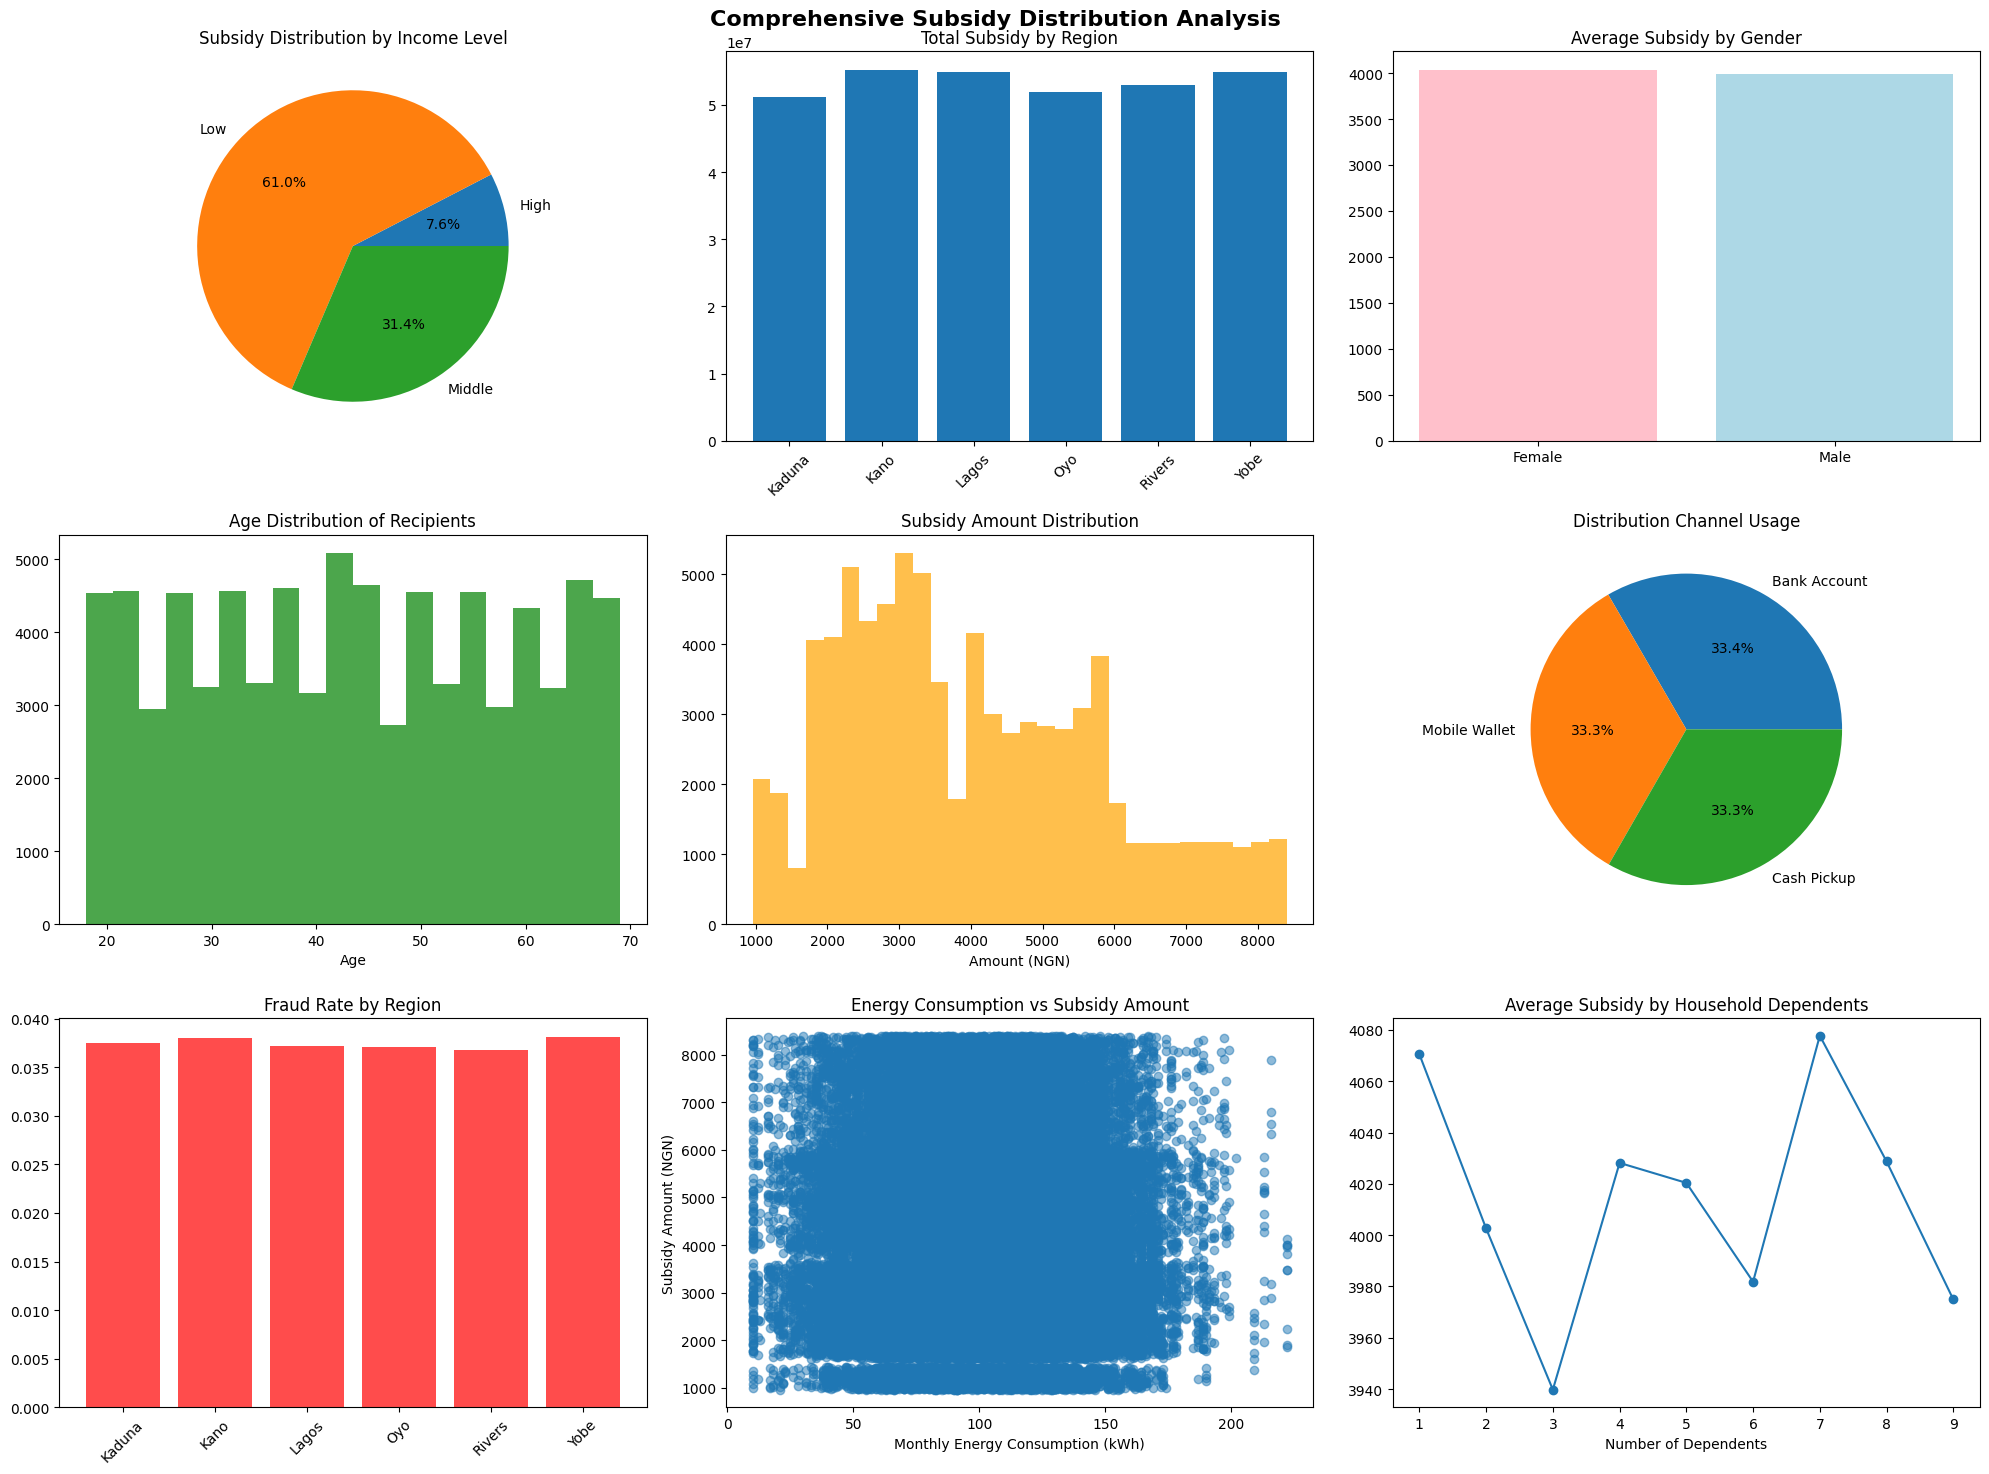

✅ Exploratory Data Analysis completed!


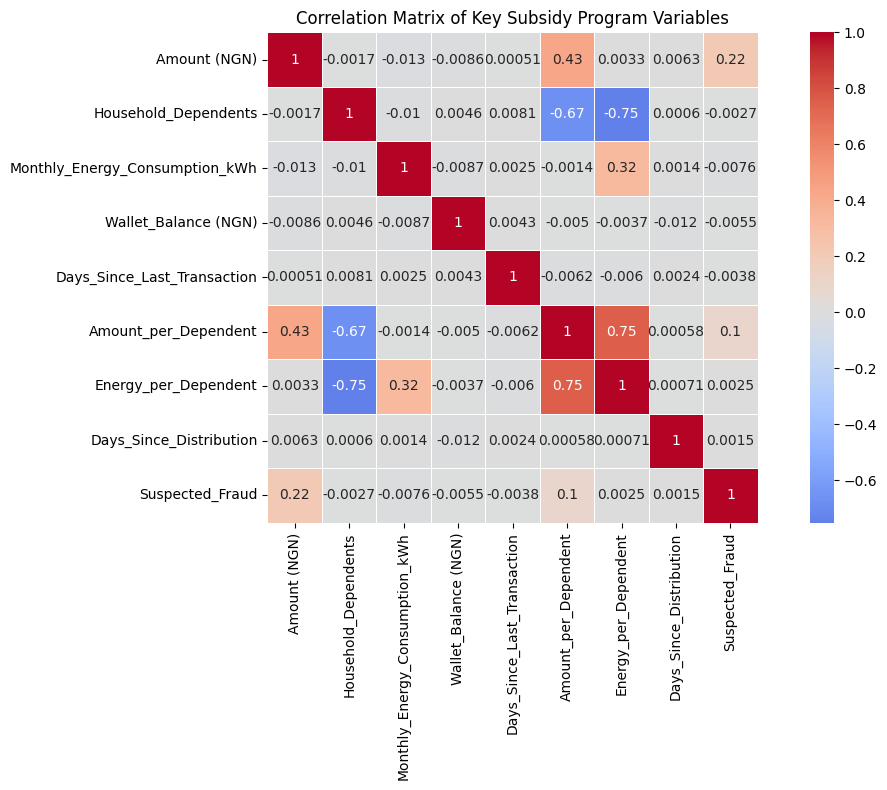

In [ ]:
def correlation_analysis():
    """Perform correlation analysis on key variables"""
    global df

    # list of desired numeric columns focusing on key subsidy features
    desired_numeric_cols = [
        'Amount (NGN)',
        'Household_Dependents',
        'Monthly_Energy_Consumption_kWh',
        'Wallet_Balance (NGN)',
        'Days_Since_Last_Transaction',
        'Amount_per_Dependent',
        'Energy_per_Dependent',
        'Days_Since_Distribution',
        'Suspected_Fraud' # numeric (0 or 1)
    ]

    # Filter for columns that exist in the current DataFrame and are numeric
    existing_numeric_cols = [col for col in desired_numeric_cols if col in df.columns and pd.api.types.is_numeric_dtype(df[col])]

    # Check if there are enough numeric columns to calculate correlation
    if len(existing_numeric_cols) < 2:
        print("Not enough numeric columns available for correlation analysis.")
        return None

    correlation_matrix = df[existing_numeric_cols].corr()

    plt.figure(figsize=(12, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
               square=True, linewidths=0.5)
    plt.title('Correlation Matrix of Key Subsidy Program Variables')
    plt.tight_layout()

    return correlation_matrix

def exploratory_data_analysis():
    """Comprehensive exploratory data analysis"""
    global df
    print("=== EXPLORATORY DATA ANALYSIS ===")

    # Create comprehensive visualizations
    fig, axes = plt.subplots(3, 3, figsize=(20, 15))
    fig.suptitle('Comprehensive Subsidy Distribution Analysis', fontsize=16, fontweight='bold')

    # 1. Subsidy distribution by income level
    if 'Income_Level' in df.columns and 'Amount (NGN)' in df.columns:
        income_subsidy = df.groupby('Income_Level')['Amount (NGN)'].sum()
        axes[0, 0].pie(income_subsidy.values, labels=income_subsidy.index, autopct='%1.1f%%')
        axes[0, 0].set_title('Subsidy Distribution by Income Level')
    else:
        axes[0, 0].set_title('Income Level or Amount (NGN) not available')
        axes[0, 0].text(0.5, 0.5, 'Data not available', horizontalalignment='center', verticalalignment='center', transform=axes[0, 0].transAxes)


    # 2. Regional distribution
    if 'Region' in df.columns and 'Amount (NGN)' in df.columns:
        regional_subsidy = df.groupby('Region')['Amount (NGN)'].sum()
        axes[0, 1].bar(regional_subsidy.index, regional_subsidy.values)
        axes[0, 1].set_title('Total Subsidy by Region')
        axes[0, 1].tick_params(axis='x', rotation=45)
    else:
        axes[0, 1].set_title('Region or Amount (NGN) not available')
        axes[0, 1].text(0.5, 0.5, 'Data not available', horizontalalignment='center', verticalalignment='center', transform=axes[0, 1].transAxes)


    # 3. Gender distribution
    if 'Gender' in df.columns and 'Amount (NGN)' in df.columns:
        gender_subsidy = df.groupby('Gender')['Amount (NGN)'].mean()
        axes[0, 2].bar(gender_subsidy.index, gender_subsidy.values, color=['pink', 'lightblue'])
        axes[0, 2].set_title('Average Subsidy by Gender')
    else:
        axes[0, 2].set_title('Gender or Amount (NGN) not available')
        axes[0, 2].text(0.5, 0.5, 'Data not available', horizontalalignment='center', verticalalignment='center', transform=axes[0, 2].transAxes)

    # 4. Age distribution of recipients
    if 'Age' in df.columns:
        axes[1, 0].hist(df['Age'], bins=20, alpha=0.7, color='green')
        axes[1, 0].set_title('Age Distribution of Recipients')
        axes[1, 0].set_xlabel('Age')
    else:
        axes[1, 0].set_title('Age data not available')
        axes[1, 0].text(0.5, 0.5, 'Data not available', horizontalalignment='center', verticalalignment='center', transform=axes[1, 0].transAxes)


    # 5. Subsidy amount distribution
    if 'Amount (NGN)' in df.columns:
        axes[1, 1].hist(df['Amount (NGN)'], bins=30, alpha=0.7, color='orange')
        axes[1, 1].set_title('Subsidy Amount Distribution')
        axes[1, 1].set_xlabel('Amount (NGN)')
    else:
        axes[1, 1].set_title('Amount (NGN) not available')
        axes[1, 1].text(0.5, 0.5, 'Data not available', horizontalalignment='center', verticalalignment='center', transform=axes[1, 1].transAxes)

    # 6. Channel usage
    if 'Channel' in df.columns:
        channel_counts = df['Channel'].value_counts()
        axes[1, 2].pie(channel_counts.values, labels=channel_counts.index, autopct='%1.1f%%')
        axes[1, 2].set_title('Distribution Channel Usage')
    else:
        axes[1, 2].set_title('Channel data not available')
        axes[1, 2].text(0.5, 0.5, 'Data not available', horizontalalignment='center', verticalalignment='center', transform=axes[1, 2].transAxes)


    # 7. Fraud by region
    if 'Region' in df.columns and 'Suspected_Fraud' in df.columns:
        fraud_by_region = df.groupby('Region')['Suspected_Fraud'].mean()
        axes[2, 0].bar(fraud_by_region.index, fraud_by_region.values, color='red', alpha=0.7)
        axes[2, 0].set_title('Fraud Rate by Region')
        axes[2, 0].tick_params(axis='x', rotation=45)
    else:
        axes[2, 0].set_title('Region or Suspected_Fraud not available')
        axes[2, 0].text(0.5, 0.5, 'Data not available', horizontalalignment='center', verticalalignment='center', transform=axes[2, 0].transAxes)


    # 8. Energy consumption vs subsidy
    if 'Monthly_Energy_Consumption_kWh' in df.columns and 'Amount (NGN)' in df.columns:
        axes[2, 1].scatter(df['Monthly_Energy_Consumption_kWh'],
                      df['Amount (NGN)'], alpha=0.5)
        axes[2, 1].set_title('Energy Consumption vs Subsidy Amount')
        axes[2, 1].set_xlabel('Monthly Energy Consumption (kWh)')
        axes[2, 1].set_ylabel('Subsidy Amount (NGN)')
    else:
        axes[2, 1].set_title('Energy Consumption or Amount (NGN) not available')
        axes[2, 1].text(0.5, 0.5, 'Data not available', horizontalalignment='center', verticalalignment='center', transform=axes[2, 1].transAxes)


    # 9. Household dependents vs subsidy
    if 'Household_Dependents' in df.columns and 'Amount (NGN)' in df.columns:
        dep_subsidy = df.groupby('Household_Dependents')['Amount (NGN)'].mean()
        axes[2, 2].plot(dep_subsidy.index, dep_subsidy.values, marker='o')
        axes[2, 2].set_title('Average Subsidy by Household Dependents')
        axes[2, 2].set_xlabel('Number of Dependents')
    else:
        axes[2, 2].set_title('Household_Dependents or Amount (NGN) not available')
        axes[2, 2].text(0.5, 0.5, 'Data not available', horizontalalignment='center', verticalalignment='center', transform=axes[2, 2].transAxes)


    plt.tight_layout()
    plt.show()

    # Additional correlation analysis
    correlation_analysis()

    print("✅ Exploratory Data Analysis completed!")

# Run this cell for EDA
exploratory_data_analysis()

## Cell 5: Unsupervised Anomaly Detection


=== UNSUPERVISED ANOMALY DETECTION ===
ISOLATION FOREST PERFORMANCE:
Accuracy: 0.842
Precision: 0.099
Recall: 0.396
F1-Score: 0.158


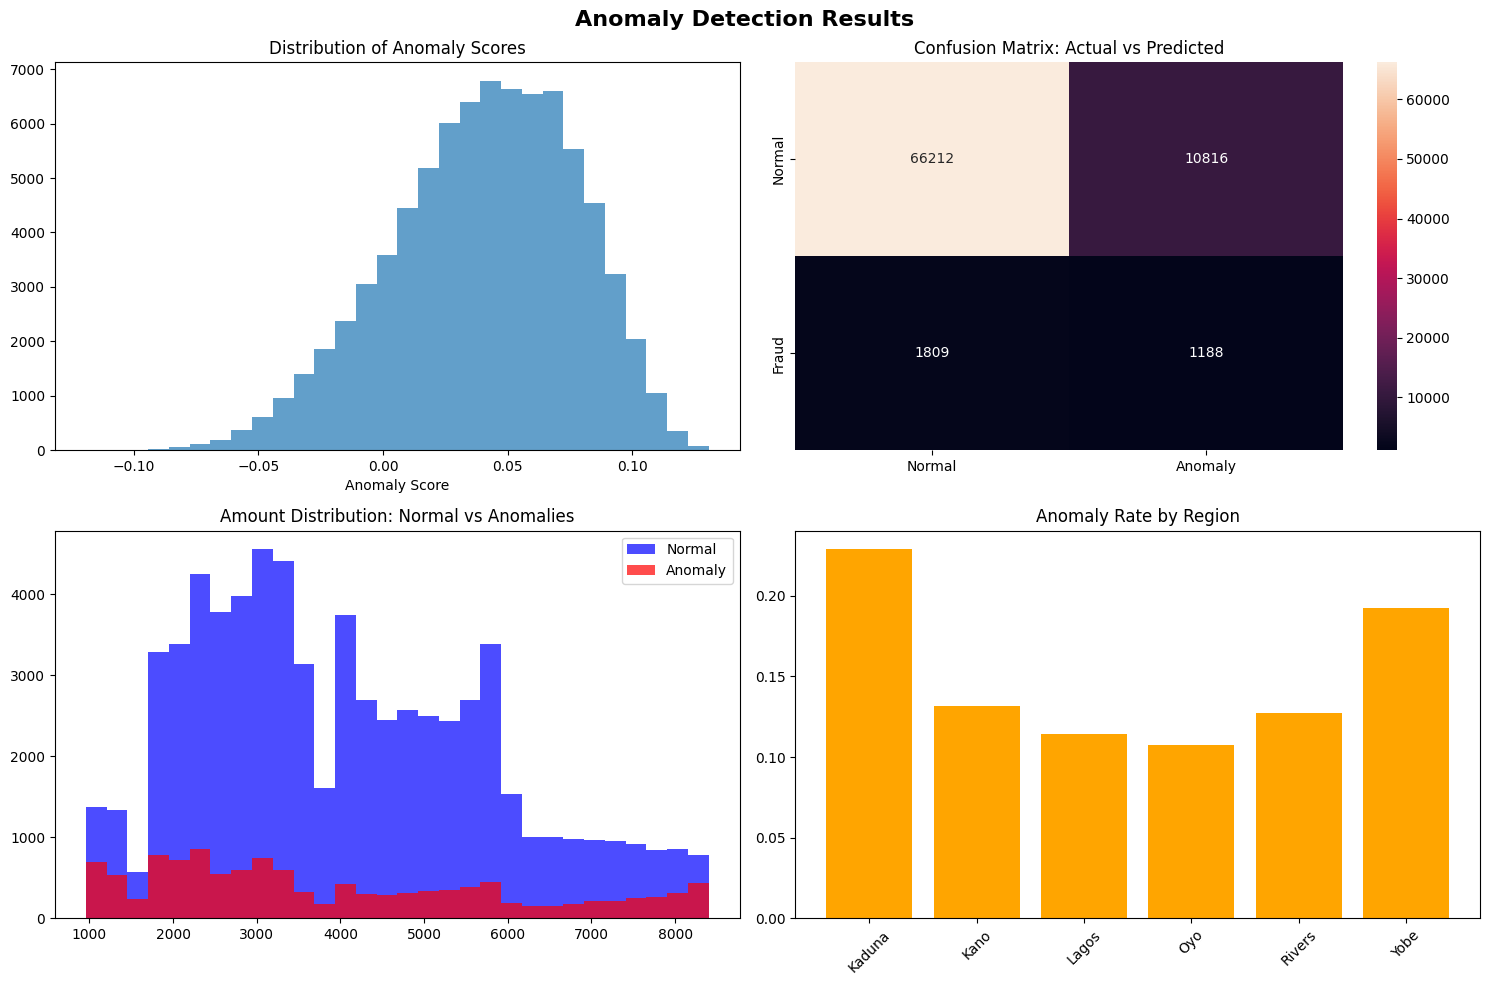

✅ Unsupervised Anomaly Detection completed!


In [ ]:
def visualize_anomaly_detection(df_encoded):
    """Visualize anomaly detection results"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Anomaly Detection Results', fontsize=16, fontweight='bold')

    # 1. Anomaly score distribution
    axes[0, 0].hist(df_encoded['Anomaly_Score'], bins=30, alpha=0.7)
    axes[0, 0].set_title('Distribution of Anomaly Scores')
    axes[0, 0].set_xlabel('Anomaly Score')

    # 2. Actual vs Predicted fraud
    confusion_mat = confusion_matrix(df_encoded['Suspected_Fraud'],
                                   df_encoded['Anomaly_Predicted'])
    sns.heatmap(confusion_mat, annot=True, fmt='d', ax=axes[0, 1],
               xticklabels=['Normal', 'Anomaly'],
               yticklabels=['Normal', 'Fraud'])
    axes[0, 1].set_title('Confusion Matrix: Actual vs Predicted')

    # 3. Amount distribution for anomalies
    normal_amounts = df_encoded[df_encoded['Anomaly_Predicted'] == 0]['Amount (NGN)']
    anomaly_amounts = df_encoded[df_encoded['Anomaly_Predicted'] == 1]['Amount (NGN)']

    axes[1, 0].hist(normal_amounts, bins=30, alpha=0.7, label='Normal', color='blue')
    axes[1, 0].hist(anomaly_amounts, bins=30, alpha=0.7, label='Anomaly', color='red')
    axes[1, 0].set_title('Amount Distribution: Normal vs Anomalies')
    axes[1, 0].legend()

    # 4. Regional anomaly distribution
    region_anomalies = df_encoded.groupby('Region')['Anomaly_Predicted'].mean()
    axes[1, 1].bar(region_anomalies.index, region_anomalies.values, color='orange')
    axes[1, 1].set_title('Anomaly Rate by Region')
    axes[1, 1].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

def anomaly_detection_unsupervised():
    """Implement unsupervised anomaly detection using Isolation Forest"""
    global df, anomaly_model, scaler
    print("=== UNSUPERVISED ANOMALY DETECTION ===")

    # Prepare features for anomaly detection
    feature_cols = [
        'Age', 'Household_Dependents', 'Monthly_Energy_Consumption_kWh',
        'Amount (NGN)', 'Wallet_Balance (NGN)',
        'Days_Since_Last_Transaction'
    ]

    # Handle categorical variables
    df_encoded = df.copy()
    le_dict = {}

    for col in ['Gender', 'Region', 'Income_Level', 'Channel', 'Subsidy_Type']:
        le = LabelEncoder()
        df_encoded[f'{col}_encoded'] = le.fit_transform(df_encoded[col])
        le_dict[col] = le
        feature_cols.append(f'{col}_encoded')

    # Prepare data
    X_anomaly = df_encoded[feature_cols].fillna(0)
    X_anomaly_scaled = scaler.fit_transform(X_anomaly)

    # Train Isolation Forest
    anomaly_model = IsolationForest(
        contamination=0.15,  # Expected fraud rate
        random_state=42,
        n_estimators=100
    )

    # Fit and predict
    anomaly_predictions = anomaly_model.fit_predict(X_anomaly_scaled)
    anomaly_scores = anomaly_model.decision_function(X_anomaly_scaled)

    # Convert predictions (-1 for anomaly, 1 for normal) to (1 for anomaly, 0 for normal)
    df_encoded['Anomaly_Predicted'] = (anomaly_predictions == -1).astype(int)
    df_encoded['Anomaly_Score'] = anomaly_scores

    # Compare with actual fraud labels
    actual_fraud = df_encoded['Suspected_Fraud']
    predicted_fraud = df_encoded['Anomaly_Predicted']

    print("ISOLATION FOREST PERFORMANCE:")
    print(f"Accuracy: {accuracy_score(actual_fraud, predicted_fraud):.3f}")
    print(f"Precision: {precision_score(actual_fraud, predicted_fraud):.3f}")
    print(f"Recall: {recall_score(actual_fraud, predicted_fraud):.3f}")
    print(f"F1-Score: {f1_score(actual_fraud, predicted_fraud):.3f}")

    # Visualize results
    visualize_anomaly_detection(df_encoded)

    print("✅ Unsupervised Anomaly Detection completed!")
    return df_encoded

# Run this cell for anomaly detection
df_encoded = anomaly_detection_unsupervised()

In [ ]:
df.head()

,National_ID,Age,Gender,Region,Income_Level,Household_Dependents,Monthly_Energy_Consumption_kWh,Subsidy_Eligibility,Subsidy_Type,Amount (NGN),Channel,Date,Wallet_Activity_Status,Wallet_Balance (NGN),Days_Since_Last_Transaction,Avg_Monthly_Wallet_Balance,Suspected_Fraud,Amount_per_Dependent,Energy_per_Dependent,Days_Since_Distribution
0,ID00001,56,Male,Lagos,Low,4,151,1,Food,2977,Mobile Wallet,2022-01-04,Active,4373.0,16.0,5986.0,0,744.25,37.75,1331
1,ID00001,56,Male,Lagos,Low,4,151,1,Food,2689,Bank Account,2020-12-20,Active,4998.0,50.0,4005.0,0,672.25,37.75,1711
2,ID00001,56,Male,Lagos,Low,4,151,1,Food,3251,Mobile Wallet,2022-06-05,Active,3353.0,76.0,2276.0,0,812.75,37.75,1179
3,ID00001,56,Male,Lagos,Low,4,151,1,Cash Transfer,6065,Mobile Wallet,2021-05-23,Active,5090.0,55.0,4347.0,0,1516.25,37.75,1557
4,ID00001,56,Male,Lagos,Low,4,151,1,Food,3201,Mobile Wallet,2023-09-17,Inactive,7870.0,3.0,5906.0,0,800.25,37.75,710


## Cell 6: Supervised Fraud Detection (Revised)


=== SUPERVISED FRAUD DETECTION ===

Training Random Forest...
Accuracy: 0.960
Precision: 0.205
Recall: 0.025
F1-Score: 0.045

Training Decision Tree...
Accuracy: 0.962
Precision: 0.361
Recall: 0.037
F1-Score: 0.067

Training Logistic Regression...
Accuracy: 0.961
Precision: 0.273
Recall: 0.025
F1-Score: 0.046

Best Model: Decision Tree (F1-Score: 0.067)


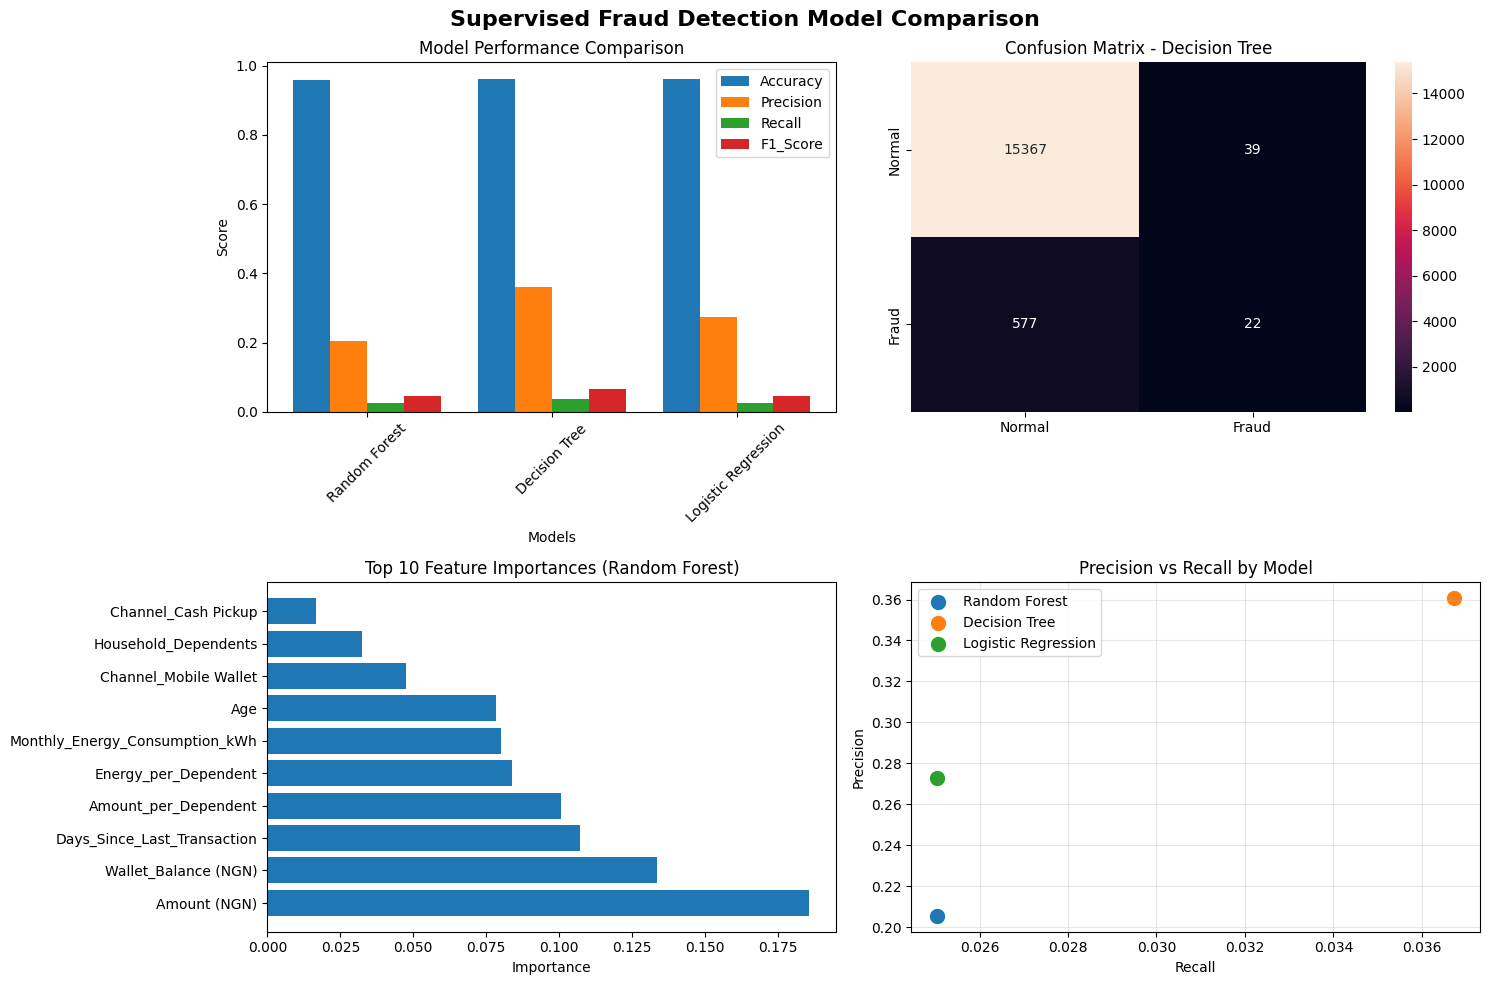

✅ Supervised Fraud Detection completed!
=== SUPERVISED FRAUD DETECTION MODEL EVALUATION ===

Evaluating Model: Random Forest
-------------------------------

Classification Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98     15406
           1       0.21      0.03      0.04       599

    accuracy                           0.96     16005
   macro avg       0.58      0.51      0.51     16005
weighted avg       0.93      0.96      0.94     16005

Confusion Matrix:
[[15348    58]
 [  584    15]]

Evaluating Model: Decision Tree
-------------------------------

Classification Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98     15406
           1       0.36      0.04      0.07       599

    accuracy                           0.96     16005
   macro avg       0.66      0.52      0.52     16005
weighted avg       0.94      0.96      0.95     16005

Confusion Matrix:
[[15367  

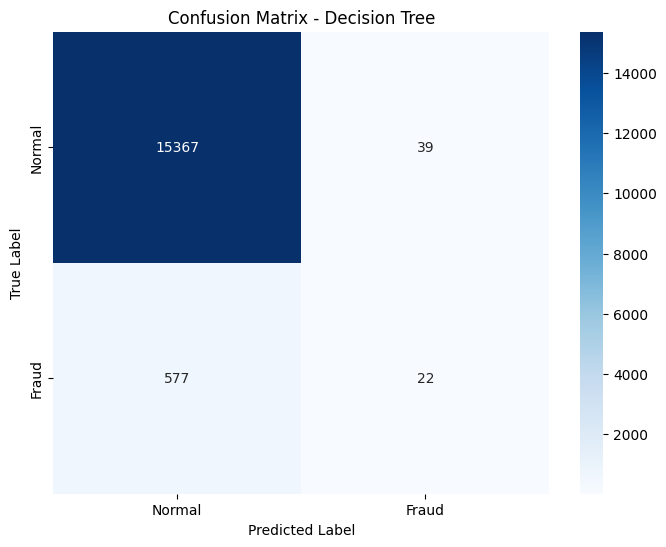


Classification Report (Best Model):
              precision    recall  f1-score   support

           0       0.96      1.00      0.98     15406
           1       0.36      0.04      0.07       599

    accuracy                           0.96     16005
   macro avg       0.66      0.52      0.52     16005
weighted avg       0.94      0.96      0.95     16005


✅ Model Evaluation completed!


In [ ]:
def visualize_model_comparison(results, y_test):
    """Visualize model comparison results"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Supervised Fraud Detection Model Comparison', fontsize=16, fontweight='bold')

    # 1. Model performance comparison
    model_names = list(results.keys())
    metrics_list = ['accuracy', 'precision', 'recall', 'f1_score']

    x = np.arange(len(model_names))
    width = 0.2

    for i, metric in enumerate(metrics_list):
        values = [results[name][metric] for name in model_names]
        axes[0, 0].bar(x + i * width, values, width, label=metric.title())

    axes[0, 0].set_xlabel('Models')
    axes[0, 0].set_ylabel('Score')
    axes[0, 0].set_title('Model Performance Comparison')
    axes[0, 0].set_xticks(x + width * 1.5)
    axes[0, 0].set_xticklabels(model_names, rotation=45)
    axes[0, 0].legend()

    # 2. Confusion matrix for best model
    best_model_name = max(results.keys(), key=lambda k: results[k]['f1_score'])
    best_predictions = results[best_model_name]['y_pred']

    cm = confusion_matrix(y_test, best_predictions)
    sns.heatmap(cm, annot=True, fmt='d', ax=axes[0, 1],
               xticklabels=['Normal', 'Fraud'],
               yticklabels=['Normal', 'Fraud'])
    axes[0, 1].set_title(f'Confusion Matrix - {best_model_name}')

    # 3. Feature importance (for Random Forest)
    if 'Random Forest' in results:
        rf_model = results['Random Forest']['model']
        # Ensure feature names match the trained model's features
        # Access X_train from the outer scope if it's not passed
        if 'X_train' in globals() and X_train is not None:
            feature_names = [col for col in X_train.columns if col in rf_model.feature_names_in_]
            if len(feature_names) > 0:
                # Get feature importances for existing features
                importances = rf_model.feature_importances_
                # Sort feature importances and select top 10
                sorted_idx = importances.argsort()[::-1][:10]
                top_feature_names = [feature_names[i] for i in sorted_idx]
                top_importances = importances[sorted_idx]

                axes[1, 0].barh(top_feature_names, top_importances)
                axes[1, 0].set_title('Top 10 Feature Importances (Random Forest)')
                axes[1, 0].set_xlabel('Importance')
            else:
                axes[1, 0].set_title('Feature Importances not available')
                axes[1, 0].text(0.5, 0.5, 'Feature names mismatch or not available', horizontalalignment='center', verticalalignment='center', transform=axes[1, 0].transAxes)
        else:
             axes[1, 0].set_title('Feature Importances not available')
             axes[1, 0].text(0.5, 0.5, 'X_train not available in global scope', horizontalalignment='center', verticalalignment='center', transform=axes[1, 0].transAxes)


    # 4. Precision-Recall by model
    precisions = [results[name]['precision'] for name in model_names]
    recalls = [results[name]['recall'] for name in model_names]

    for i, name in enumerate(model_names):
        axes[1, 1].scatter(recalls[i], precisions[i], s=100, label=name)

    axes[1, 1].set_xlabel('Recall')
    axes[1, 1].set_ylabel('Precision')
    axes[1, 1].set_title('Precision vs Recall by Model')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


def supervised_fraud_detection():
    """Implement supervised machine learning for fraud detection"""
    global df, fraud_models, X_train, X_test, y_test # Add X_test, y_test to global scope
    print("=== SUPERVISED FRAUD DETECTION ===")

    # Prepare features
    feature_cols = [
        'Age', 'Household_Dependents', 'Monthly_Energy_Consumption_kWh',
        'Amount (NGN)', 'Wallet_Balance (NGN)',
        'Days_Since_Last_Transaction', 'Amount_per_Dependent', 'Energy_per_Dependent'
    ]

    # Encode categorical variables
    df_ml = df.copy()

    for col in ['Gender', 'Region', 'Income_Level', 'Channel', 'Subsidy_Type']:
        dummies = pd.get_dummies(df_ml[col], prefix=col)
        df_ml = pd.concat([df_ml, dummies], axis=1)
        # Only add dummy columns that don't already exist in feature_cols
        new_dummy_cols = [col for col in dummies.columns.tolist() if col not in feature_cols]
        feature_cols.extend(new_dummy_cols)


    # Prepare data
    # Ensure all selected feature columns exist in the dataframe
    existing_feature_cols = [col for col in feature_cols if col in df_ml.columns]
    X = df_ml[existing_feature_cols].fillna(0)
    y = df_ml['Suspected_Fraud']

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # Scale features
    scaler_ml = StandardScaler()
    # Only scale numeric columns
    numeric_cols_train = X_train.select_dtypes(include=np.number).columns
    numeric_cols_test = X_test.select_dtypes(include=np.number).columns


    X_train_scaled = X_train.copy()
    X_test_scaled = X_test.copy()

    if len(numeric_cols_train) > 0:
        X_train_scaled[numeric_cols_train] = scaler_ml.fit_transform(X_train[numeric_cols_train])
    if len(numeric_cols_test) > 0:
        X_test_scaled[numeric_cols_test] = scaler_ml.transform(X_test[numeric_cols_test])


    # Train multiple models
    models = {
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
        'Decision Tree': DecisionTreeClassifier(random_state=42, max_depth=10),
        'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000)
    }

    results = {}

    for name, model in models.items():
        print(f"\nTraining {name}...")

        # Train model
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]


        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)

        results[name] = {
            'model': model,
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'y_pred': y_pred,
            'y_pred_proba': y_pred_proba,
            'y_test': y_test # Store y_test here
        }

        print(f"Accuracy: {accuracy:.3f}")
        print(f"Precision: {precision:.3f}")
        print(f"Recall: {recall:.3f}")
        print(f"F1-Score: {f1:.3f}")

    # Store best model and all results
    best_model_name = max(results.keys(), key=lambda k: results[k]['f1_score'])
    fraud_models = results # Store the entire results dictionary
    best_fraud_model = results[best_model_name]['model']

    print(f"\nBest Model: {best_model_name} (F1-Score: {results[best_model_name]['f1_score']:.3f})")

    # Visualize results
    # Pass y_test to the visualization function
    visualize_model_comparison(results, y_test)

    print("✅ Supervised Fraud Detection completed!")
    # Return results, X_test, and y_test
    return results, X_test, y_test

# Run this cell for supervised fraud detection
fraud_results, X_test, y_test = supervised_fraud_detection()


## Cell 6.1: Model Evaluation


In [ ]:
print("=== SUPERVISED FRAUD DETECTION MODEL EVALUATION ===")
print("="*60)

# Access the trained models and their evaluation results
if 'fraud_models' in globals() and fraud_models and 'y_test' in globals() and y_test is not None:
    # Evaluate each model
    for name, result in fraud_models.items():
        print(f"\nEvaluating Model: {name}")
        print("-" * (len(name) + 18))

        # Use the globally available y_test
        y_pred = result['y_pred']

        # Print Classification Report
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred))

        # Print Confusion Matrix
        print("Confusion Matrix:")
        print(confusion_matrix(y_test, y_pred))

    # Identify the best performing model based on F1-score
    best_model_name = max(fraud_models.keys(), key=lambda k: fraud_models[k]['f1_score'])
    best_model_results = fraud_models[best_model_name]
    y_pred_best = best_model_results['y_pred']

    print(f"\n=== BEST PERFORMING MODEL: {best_model_name} ===")
    print("-" * (len(best_model_name) + 30))

    # Generate Confusion Matrix Visualization for the best model
    print("\nConfusion Matrix Visualization (Best Model):")
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrix(y_test, y_pred_best), annot=True, fmt='d', cmap='Blues',
                xticklabels=['Normal', 'Fraud'], yticklabels=['Normal', 'Fraud'])
    plt.title(f'Confusion Matrix - {best_model_name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    # Generate Classification Report Visualization for the best model (using text representation for simplicity)
    print("\nClassification Report (Best Model):")
    print(classification_report(y_test, y_pred_best))

else:
    print("Fraud models or y_test not available for evaluation.")

print("\n✅ Model Evaluation completed!")

## Cell 7: Propensity Score Matching



=== PROPENSITY SCORE MATCHING ANALYSIS ===
Performing propensity score matching...
Treatment group size: 26560
Control group size: 53465
Matched dataset size: 53120

=== BALANCE ASSESSMENT ===
BEFORE MATCHING:
Age: Treated=43.14, Control=43.62, Diff=0.47
Household_Dependents: Treated=6.47, Control=4.36, Diff=2.11

AFTER MATCHING:
Age: Treated=43.14, Control=20.00, Diff=23.14
Household_Dependents: Treated=6.47, Control=3.00, Diff=3.47


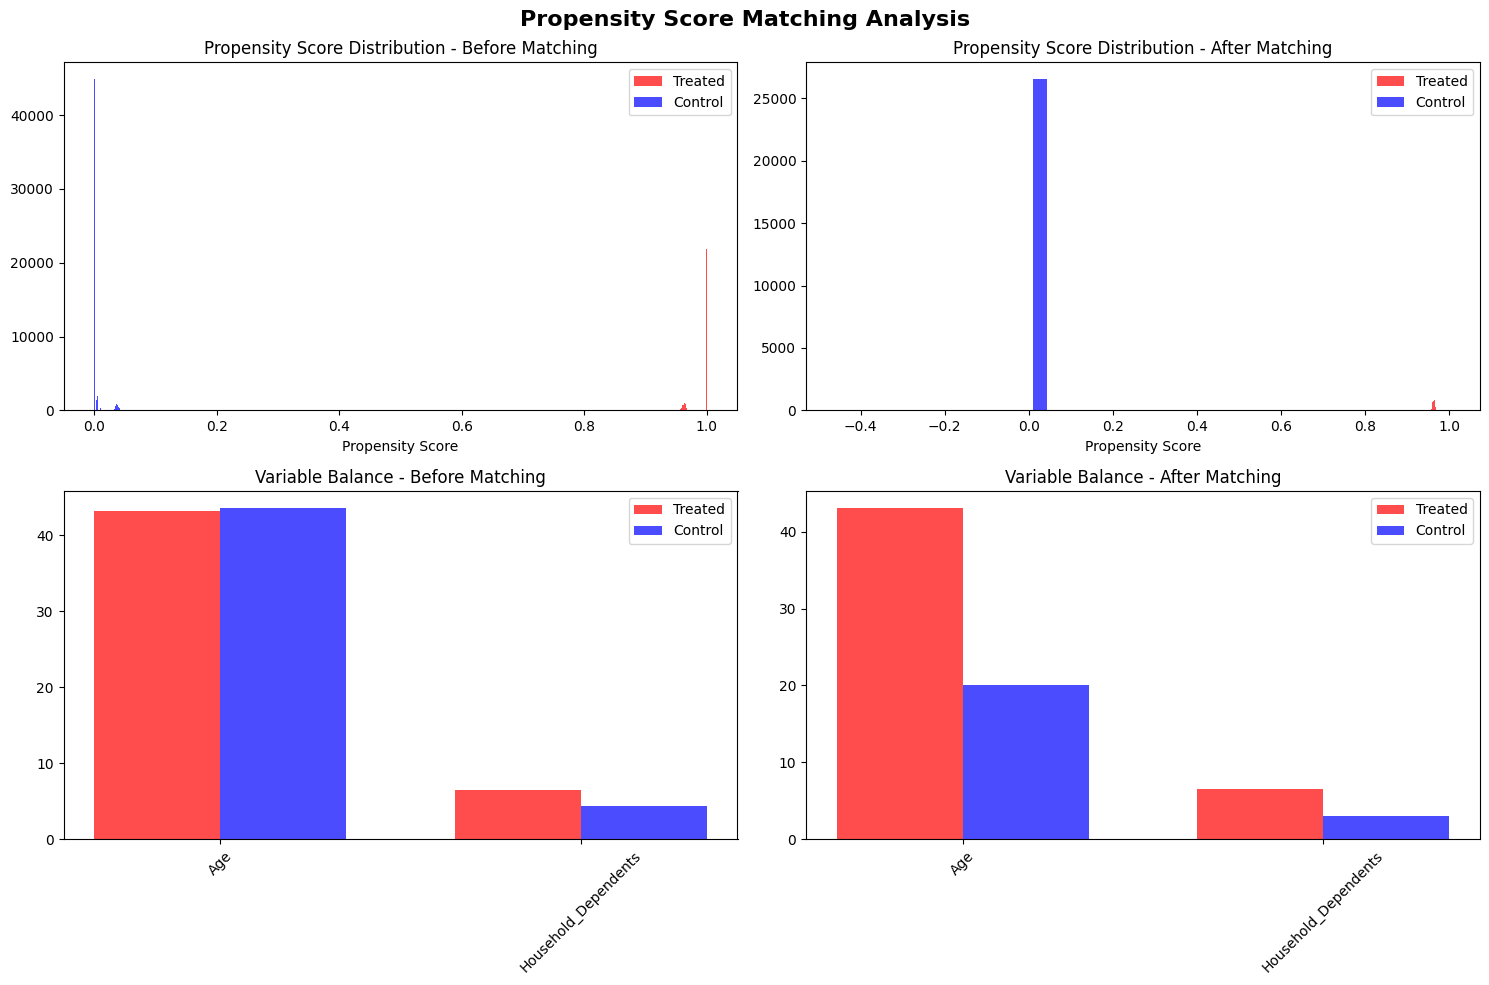


=== TREATMENT EFFECT ANALYSIS ===
Average Treatment Effect (ATE): 1916.10 NGN
Treated group mean: 5021.10 NGN
Control group mean: 3105.00 NGN
T-statistic: 179.306
P-value: 0.000
Statistically significant: Yes

=== BEHAVIORAL DIFFERENCES ANALYSIS ===

Analysis for: Wallet_Activity_Status
  Treated distribution:
Wallet_Activity_Status
Active        0.900226
Inactive      0.067922
Suspicious    0.031852
Name: proportion, dtype: float64
  Control distribution:
Wallet_Activity_Status
Active    1.0
Name: proportion, dtype: float64

Analysis for: Days_Since_Last_Transaction
  Treated mean: 50.03
  Control mean: 21.00
  T-statistic: 283.996, P-value: 0.000
  Statistically significant difference: Yes

Analysis for: Avg_Monthly_Wallet_Balance
  Treated mean: 4004.82
  Control mean: 2478.00
  T-statistic: 288.749, P-value: 0.000
  Statistically significant difference: Yes

=== PROGRAM COVERAGE BIASES ANALYSIS ===
Comparing demographic distributions between matched treated and control groups:

An

In [ ]:
def propensity_score_matching(treatment_col='Subsidy_Eligibility'):
    """Implement Propensity Score Matching"""
    global df, propensity_model, matched_df # Add matched_df to global scope
    print("=== PROPENSITY SCORE MATCHING ANALYSIS ===")

    # Features for propensity scoring (excluding outcome variables)
    propensity_features = [
        'Age', 'Household_Dependents', 'Monthly_Energy_Consumption_kWh',
        'Regional_Poverty_Rate'
    ]

    # Add encoded categorical features
    df_encoded = df.copy()
    categorical_features = ['Gender', 'Region', 'Income_Level']

    for col in categorical_features:
        dummies = pd.get_dummies(df_encoded[col], prefix=col)
        df_encoded = pd.concat([df_encoded, dummies], axis=1)
        propensity_features.extend(dummies.columns.tolist())

    # Prepare data
    # Ensure all features exist in the dataframe before selecting them
    existing_propensity_features = [feature for feature in propensity_features if feature in df_encoded.columns]
    X = df_encoded[existing_propensity_features].fillna(0)
    y = df_encoded[treatment_col]

    # Fit propensity score model
    propensity_model = LogisticRegression(random_state=42, max_iter=1000)
    propensity_model.fit(X, y)

    # Calculate propensity scores
    propensity_scores = propensity_model.predict_proba(X)[:, 1]
    df_encoded['Propensity_Score'] = propensity_scores

    # Perform matching using nearest neighbors
    print("Performing propensity score matching...")

    # Separate treatment and control groups
    treated = df_encoded[df_encoded[treatment_col] == 1]
    control = df_encoded[df_encoded[treatment_col] == 0]

    print(f"Treatment group size: {len(treated)}")
    print(f"Control group size: {len(control)}")

    # Use nearest neighbors for matching
    nn = NearestNeighbors(n_neighbors=1, metric='manhattan')
    nn.fit(control[['Propensity_Score']])

    # Find matches for treated units
    distances, indices = nn.kneighbors(treated[['Propensity_Score']])

    # Create matched dataset
    matched_control = control.iloc[indices.flatten()]
    matched_treated = treated.copy()

    # Reset indices to avoid conflicts
    matched_control.reset_index(drop=True, inplace=True)
    matched_treated.reset_index(drop=True, inplace=True)

    # Combine matched samples
    matched_df = pd.concat([matched_treated, matched_control], ignore_index=True)

    print(f"Matched dataset size: {len(matched_df)}")

    # Assess balance after matching
    print("\n=== BALANCE ASSESSMENT ===")

    # Before matching balance
    print("BEFORE MATCHING:")
    # Ensure variables exist before calculating means
    balance_variables = [var for var in ['Age', 'Household_Dependents', 'Regional_Poverty_Rate'] if var in df_encoded.columns]
    for feature in balance_variables:
        treated_mean = treated[feature].mean()
        control_mean = control[feature].mean()
        diff = abs(treated_mean - control_mean)
        print(f"{feature}: Treated={treated_mean:.2f}, Control={control_mean:.2f}, Diff={diff:.2f}")

    # After matching balance
    print("\nAFTER MATCHING:")
    matched_treated_final = matched_df[matched_df[treatment_col] == 1]
    matched_control_final = matched_df[matched_df[treatment_col] == 0]

    for feature in balance_variables:
        treated_mean = matched_treated_final[feature].mean()
        control_mean = matched_control_final[feature].mean()
        diff = abs(treated_mean - control_mean)
        print(f"{feature}: Treated={treated_mean:.2f}, Control={control_mean:.2f}, Diff={diff:.2f}")

    # Visualize propensity scores
    visualize_propensity_scores(df_encoded, matched_df, treatment_col)

    # Calculate treatment effect
    treatment_effect = calculate_treatment_effect(matched_df, treatment_col)

    # Analyze Behavioral Differences
    analyze_behavioral_differences(matched_df, treatment_col)

    # Analyze Program Coverage Biases
    analyze_coverage_biases(matched_df, treatment_col)


    print("✅ Propensity Score Matching completed!")
    return matched_df, treatment_effect

def visualize_propensity_scores(df_original, df_matched, treatment_col):
    """Visualize propensity score distributions before and after matching"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Propensity Score Matching Analysis', fontsize=16, fontweight='bold')

    # 1. Propensity score distribution before matching
    if 'Propensity_Score' in df_original.columns:
        treated_before = df_original[df_original[treatment_col] == 1]['Propensity_Score']
        control_before = df_original[df_original[treatment_col] == 0]['Propensity_Score']

        axes[0, 0].hist(treated_before, bins=30, alpha=0.7, label='Treated', color='red')
        axes[0, 0].hist(control_before, bins=30, alpha=0.7, label='Control', color='blue')
        axes[0, 0].set_title('Propensity Score Distribution - Before Matching')
        axes[0, 0].set_xlabel('Propensity Score')
        axes[0, 0].legend()
    else:
        axes[0, 0].set_title('Propensity Score data not available')
        axes[0, 0].text(0.5, 0.5, 'Data not available', horizontalalignment='center', verticalalignment='center', transform=axes[0, 0].transAxes)


    # 2. Propensity score distribution after matching
    if 'Propensity_Score' in df_matched.columns:
        treated_after = df_matched[df_matched[treatment_col] == 1]['Propensity_Score']
        control_after = df_matched[df_matched[treatment_col] == 0]['Propensity_Score']

        axes[0, 1].hist(treated_after, bins=30, alpha=0.7, label='Treated', color='red')
        axes[0, 1].hist(control_after, bins=30, alpha=0.7, label='Control', color='blue')
        axes[0, 1].set_title('Propensity Score Distribution - After Matching')
        axes[0, 1].set_xlabel('Propensity Score')
        axes[0, 1].legend()
    else:
        axes[0, 1].set_title('Propensity Score data not available')
        axes[0, 1].text(0.5, 0.5, 'Data not available', horizontalalignment='center', verticalalignment='center', transform=axes[0, 1].transAxes)


    # 3. Balance plot for key variables before matching
    variables = ['Age', 'Household_Dependents', 'Regional_Poverty_Rate']
    existing_variables_before = [var for var in variables if var in df_original.columns]
    if existing_variables_before:
        treated_means_before = [df_original[df_original[treatment_col] == 1][var].mean() for var in existing_variables_before]
        control_means_before = [df_original[df_original[treatment_col] == 0][var].mean() for var in existing_variables_before]

        x = np.arange(len(existing_variables_before))
        width = 0.35

        axes[1, 0].bar(x - width/2, treated_means_before, width, label='Treated', color='red', alpha=0.7)
        axes[1, 0].bar(x + width/2, control_means_before, width, label='Control', color='blue', alpha=0.7)
        axes[1, 0].set_title('Variable Balance - Before Matching')
        axes[1, 0].set_xticks(x)
        axes[1, 0].set_xticklabels(existing_variables_before, rotation=45)
        axes[1, 0].legend()
    else:
        axes[1, 0].set_title('Variable Balance Before Matching not available')
        axes[1, 0].text(0.5, 0.5, 'Required data not available', horizontalalignment='center', verticalalignment='center', transform=axes[1, 0].transAxes)


    # 4. Balance plot for key variables after matching
    existing_variables_after = [var for var in variables if var in df_matched.columns]
    if existing_variables_after:
        treated_means_after = [df_matched[df_matched[treatment_col] == 1][var].mean() for var in existing_variables_after]
        control_means_after = [df_matched[df_matched[treatment_col] == 0][var].mean() for var in existing_variables_after]

        x = np.arange(len(existing_variables_after))
        width = 0.35

        axes[1, 1].bar(x - width/2, treated_means_after, width, label='Treated', color='red', alpha=0.7)
        axes[1, 1].bar(x + width/2, control_means_after, width, label='Control', color='blue', alpha=0.7)
        axes[1, 1].set_title('Variable Balance - After Matching')
        axes[1, 1].set_xticks(x)
        axes[1, 1].set_xticklabels(existing_variables_after, rotation=45)
        axes[1, 1].legend()
    else:
        axes[1, 1].set_title('Variable Balance After Matching not available')
        axes[1, 1].text(0.5, 0.5, 'Required data not available', horizontalalignment='center', verticalalignment='center', transform=axes[1, 1].transAxes)


    plt.tight_layout()
    plt.show()

def calculate_treatment_effect(matched_df, treatment_col):
    """Calculate Average Treatment Effect (ATE)"""
    print("\n=== TREATMENT EFFECT ANALYSIS ===")

    # Outcome variable
    outcome_var = 'Amount (NGN)'

    if outcome_var in matched_df.columns:
        treated_outcomes = matched_df[matched_df[treatment_col] == 1][outcome_var]
        control_outcomes = matched_df[matched_df[treatment_col] == 0][outcome_var]

        # Calculate ATE
        ate = treated_outcomes.mean() - control_outcomes.mean()

        # Statistical significance test (t-test)
        from scipy import stats
        t_stat, p_value = stats.ttest_ind(treated_outcomes, control_outcomes)

        print(f"Average Treatment Effect (ATE): {ate:.2f} NGN")
        print(f"Treated group mean: {treated_outcomes.mean():.2f} NGN")
        print(f"Control group mean: {control_outcomes.mean():.2f} NGN")
        print(f"T-statistic: {t_stat:.3f}")
        print(f"P-value: {p_value:.3f}")
        print(f"Statistically significant: {'Yes' if p_value < 0.05 else 'No'}")

        return {
            'ate': ate,
            'treated_mean': treated_outcomes.mean(),
            'control_mean': control_outcomes.mean(),
            't_statistic': t_stat,
            'p_value': p_value,
            'significant': p_value < 0.05
        }
    else:
        print(f"Outcome variable '{outcome_var}' not found in matched dataset. Cannot calculate treatment effect.")
        return None

def analyze_behavioral_differences(matched_df, treatment_col):
    """Analyze behavioral differences between matched treated and control groups"""
    print("\n=== BEHAVIORAL DIFFERENCES ANALYSIS ===")

    behavioral_cols = ['Wallet_Activity_Status', 'Days_Since_Last_Transaction', 'Avg_Monthly_Wallet_Balance']
    existing_behavioral_cols = [col for col in behavioral_cols if col in matched_df.columns]

    if not existing_behavioral_cols:
        print("Skipping behavioral analysis: Required behavioral columns not found in matched data.")
        return

    matched_treated = matched_df[matched_df[treatment_col] == 1]
    matched_control = matched_df[matched_df[treatment_col] == 0]

    for col in existing_behavioral_cols:
        print(f"\nAnalysis for: {col}")
        if pd.api.types.is_numeric_dtype(matched_df[col]):
            treated_mean = matched_treated[col].mean()
            control_mean = matched_control[col].mean()
            # Perform t-test for numerical features
            from scipy import stats
            t_stat, p_value = stats.ttest_ind(matched_treated[col].dropna(), matched_control[col].dropna())
            print(f"  Treated mean: {treated_mean:.2f}")
            print(f"  Control mean: {control_mean:.2f}")
            print(f"  T-statistic: {t_stat:.3f}, P-value: {p_value:.3f}")
            print(f"  Statistically significant difference: {'Yes' if p_value < 0.05 else 'No'}")
        else:
            # Analyze distribution for categorical features
            treated_dist = matched_treated[col].value_counts(normalize=True)
            control_dist = matched_control[col].value_counts(normalize=True)
            print("  Treated distribution:")
            print(treated_dist)
            print("  Control distribution:")
            print(control_dist)

def analyze_coverage_biases(matched_df, treatment_col):
    """Analyze program coverage biases by comparing demographic distributions"""
    print("\n=== PROGRAM COVERAGE BIASES ANALYSIS ===")

    demographic_cols = ['Age', 'Gender', 'Region', 'Income_Level', 'Household_Dependents']
    existing_demographic_cols = [col for col in demographic_cols if col in matched_df.columns]

    if not existing_demographic_cols:
        print("Skipping coverage bias analysis: Required demographic columns not found in matched data.")
        return

    matched_treated = matched_df[matched_df[treatment_col] == 1]
    matched_control = matched_df[matched_df[treatment_col] == 0]

    print("Comparing demographic distributions between matched treated and control groups:")

    for col in existing_demographic_cols:
        print(f"\nAnalysis for: {col}")
        if pd.api.types.is_numeric_dtype(matched_df[col]):
            # Compare means for numerical demographic features
            treated_mean = matched_treated[col].mean()
            control_mean = matched_control[col].mean()
            # Perform t-test for numerical features
            from scipy import stats
            t_stat, p_value = stats.ttest_ind(matched_treated[col].dropna(), matched_control[col].dropna())
            print(f"  Treated mean: {treated_mean:.2f}")
            print(f"  Control mean: {control_mean:.2f}")
            print(f"  T-statistic: {t_stat:.3f}, P-value: {p_value:.3f}")
            print(f"  Statistically significant difference: {'Yes' if p_value < 0.05 else 'No'}")
        else:
            # Compare distributions for categorical demographic features
            treated_dist = matched_treated[col].value_counts(normalize=True)
            control_dist = matched_control[col].value_counts(normalize=True)
            print("  Treated distribution:")
            print(treated_dist)
            print("  Control distribution:")
            print(control_dist)

# Run this cell for propensity score matching
matched_data, treatment_effect = propensity_score_matching()

## Cell 8: Geographic Analysis and Mapping


=== GEOGRAPHIC ANALYSIS (REGIONAL) ===
Regional Summary Statistics:
        Total_Amount  Avg_Amount  Beneficiary_Count  Fraud_Rate  \
Region                                                            
Kaduna      51257395     4028.09              12725        0.04   
Kano        55223426     3953.85              13967        0.04   
Lagos       54875042     4047.13              13559        0.04   
Oyo         51911097     4021.62              12908        0.04   
Rivers      53021932     4005.59              13237        0.04   
Yobe        54955843     4032.27              13629        0.04   

        Avg_Energy_Consumption                    Income_Level_Distribution  
Region                                                                       
Kaduna                   99.72  {'Low': 6352, 'Middle': 4335, 'High': 2038}  
Kano                     99.49  {'Low': 6434, 'Middle': 5344, 'High': 2189}  
Lagos                    98.43  {'Low': 6861, 'Middle': 4681, 'High': 2017}  
Oyo  

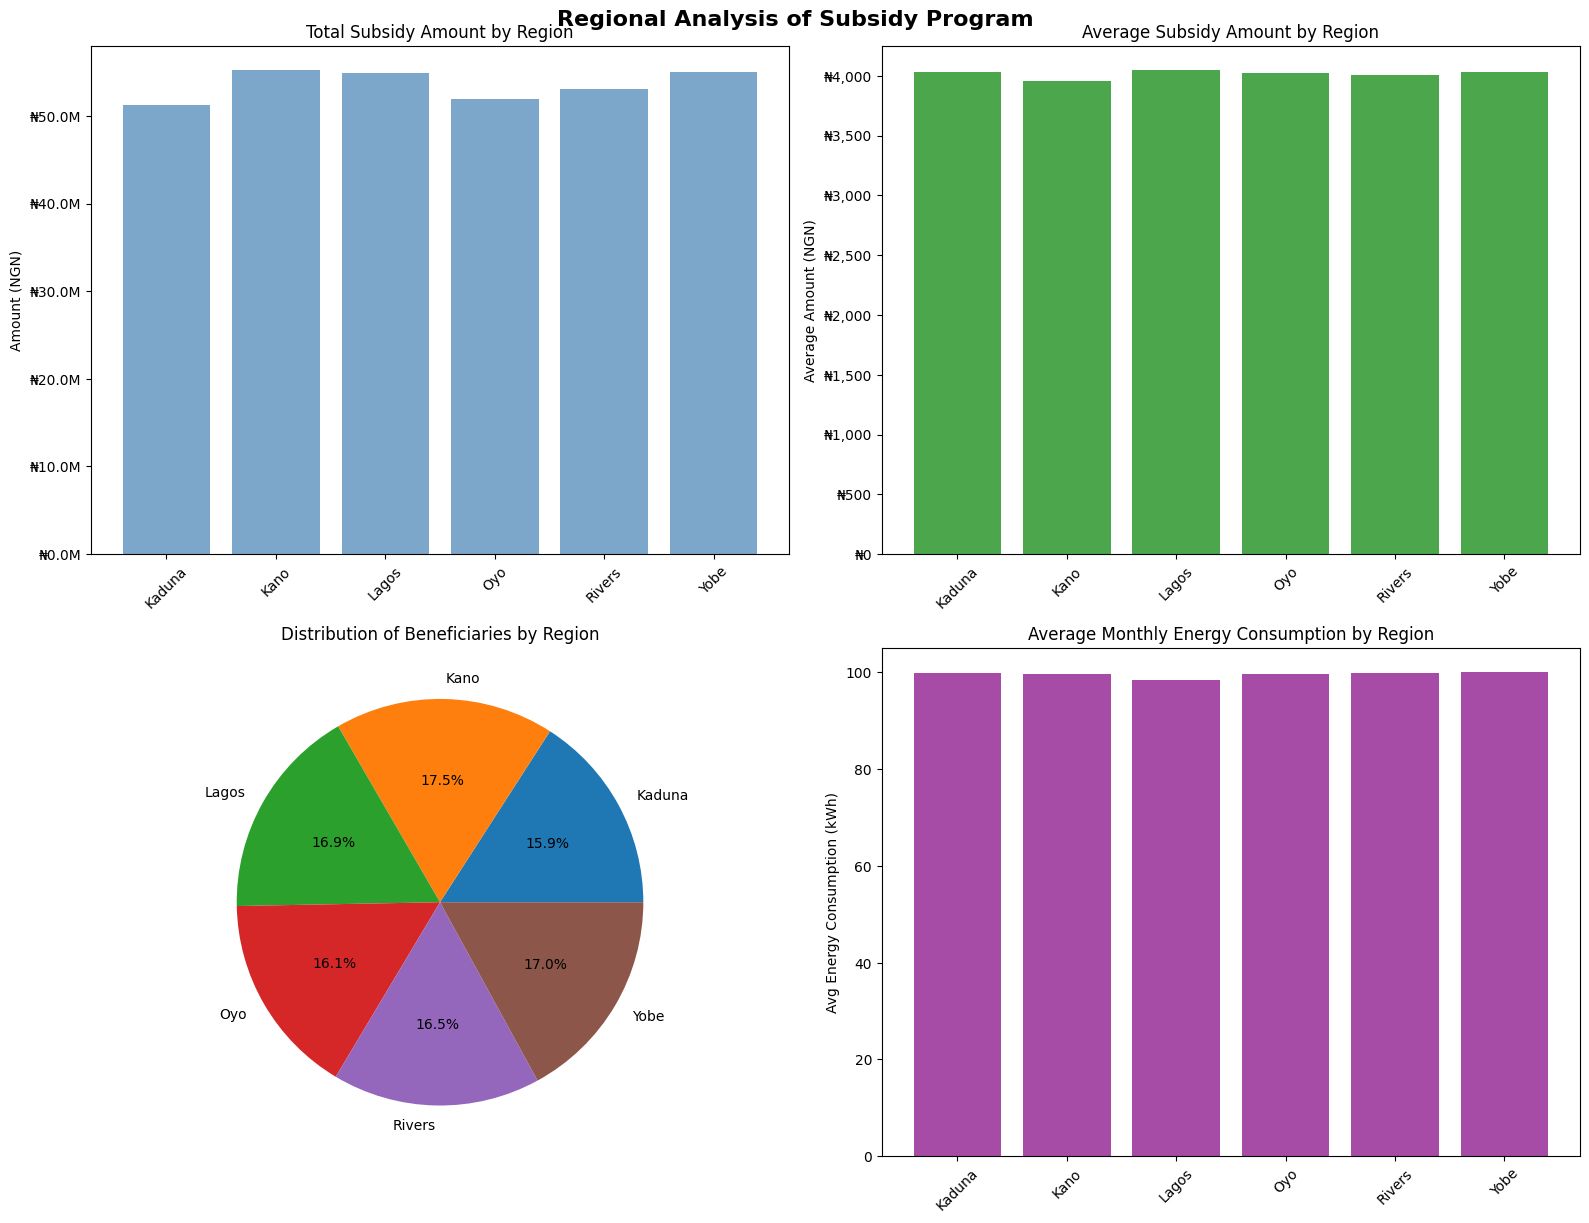

In [ ]:
def create_geographic_analysis():
    """Create comprehensive geographic analysis based on regions"""
    global df
    print("=== GEOGRAPHIC ANALYSIS (REGIONAL) ===")

    # Regional summary statistics based on available columns
    required_geo_cols = ['Region', 'Amount (NGN)', 'Suspected_Fraud', 'Income_Level', 'Monthly_Energy_Consumption_kWh']
    if all(col in df.columns for col in required_geo_cols):
        regional_stats = df.groupby('Region').agg({
            'Amount (NGN)': ['sum', 'mean', 'count'],
            'Suspected_Fraud': 'mean',
            'Monthly_Energy_Consumption_kWh': 'mean', # Include average energy consumption
            # Analyze income level distribution by region
            'Income_Level': lambda x: x.value_counts().to_dict()
        }).round(2)

        # Flatten the multi-level columns for easier access
        regional_stats.columns = ['Total_Amount', 'Avg_Amount', 'Beneficiary_Count', 'Fraud_Rate', 'Avg_Energy_Consumption', 'Income_Level_Distribution']


        print("Regional Summary Statistics:")
        print(regional_stats)

        # Create static visualizations based on regional data
        create_geographic_visualizations(regional_stats)

        return regional_stats, None # No interactive map without lat/lon
    else:
        print("Skipping regional geographic analysis due to missing required columns (Region, Amount (NGN), Suspected_Fraud, Income_Level, Monthly_Energy_Consumption_kWh).")
        return None, None


def create_geographic_visualizations(regional_stats):
    """Create static regional geographic visualizations"""
    if regional_stats is not None:
        fig, axes = plt.subplots(3, 2, figsize=(16, 18)) # Increased rows for new plot
        fig.suptitle('Regional Analysis of Subsidy Program', fontsize=16, fontweight='bold')

        # Flatten axes array for easier indexing
        axes = axes.flatten()

        # 1. Total subsidies by region
        axes[0].bar(regional_stats.index, regional_stats['Total_Amount'],
                       color='steelblue', alpha=0.7)
        axes[0].set_title('Total Subsidy Amount by Region')
        axes[0].set_ylabel('Amount (NGN)')
        axes[0].tick_params(axis='x', rotation=45)
        axes[0].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'₦{x/1e6:.1f}M'))

        # 2. Average subsidy amount by region (shifted to fill fraud plot's position)
        axes[1].bar(regional_stats.index, regional_stats['Avg_Amount'],
                       color='green', alpha=0.7)
        axes[1].set_title('Average Subsidy Amount by Region')
        axes[1].set_ylabel('Average Amount (NGN)')
        axes[1].tick_params(axis='x', rotation=45)
        axes[1].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'₦{x:,.0f}'))

        # 3. Beneficiary distribution by region (shifted)
        axes[2].pie(regional_stats['Beneficiary_Count'],
                       labels=regional_stats.index, autopct='%1.1f%%')
        axes[2].set_title('Distribution of Beneficiaries by Region')

        # 4. Average Energy Consumption by Region (New Plot, shifted)
        axes[3].bar(regional_stats.index, regional_stats['Avg_Energy_Consumption'],
                       color='purple', alpha=0.7)
        axes[3].set_title('Average Monthly Energy Consumption by Region')
        axes[3].set_ylabel('Avg Energy Consumption (kWh)')
        axes[3].tick_params(axis='x', rotation=45)

        # Hide the unused subplots (now 2 unused, previously 1)
        for i in range(4, len(axes)):
             fig.delaxes(axes[i])


        plt.tight_layout()
        plt.show()
    else:
        print("Skipping regional geographic visualizations as regional stats are not available.")


# Run this cell for geographic analysis
regional_analysis, interactive_map = create_geographic_analysis()

## Cell 9: Performance Metrics Dashboard


=== PERFORMANCE METRICS DASHBOARD ===
=== KEY PERFORMANCE INDICATORS ===
Total Beneficiaries: 80,025
Total Amount Distributed: ₦321,244,735
Average Subsidy per Beneficiary: ₦4,014
Cost per Beneficiary: ₦4,014

Subsidy Coverage Rate: 100.0%
Targeting Accuracy: 48.8%
Leakage Rate: 66.8%
Overall Fraud Rate: 3.7%

=== CHANNEL EFFICIENCY ===
               Total_Amount  Avg_Amount  Count  Fraud_Rate
Channel                                                   
Bank Account      106904707     4004.22  26698        0.00
Cash Pickup       107160241     4022.68  26639        0.00
Mobile Wallet     107179787     4016.03  26688        0.11


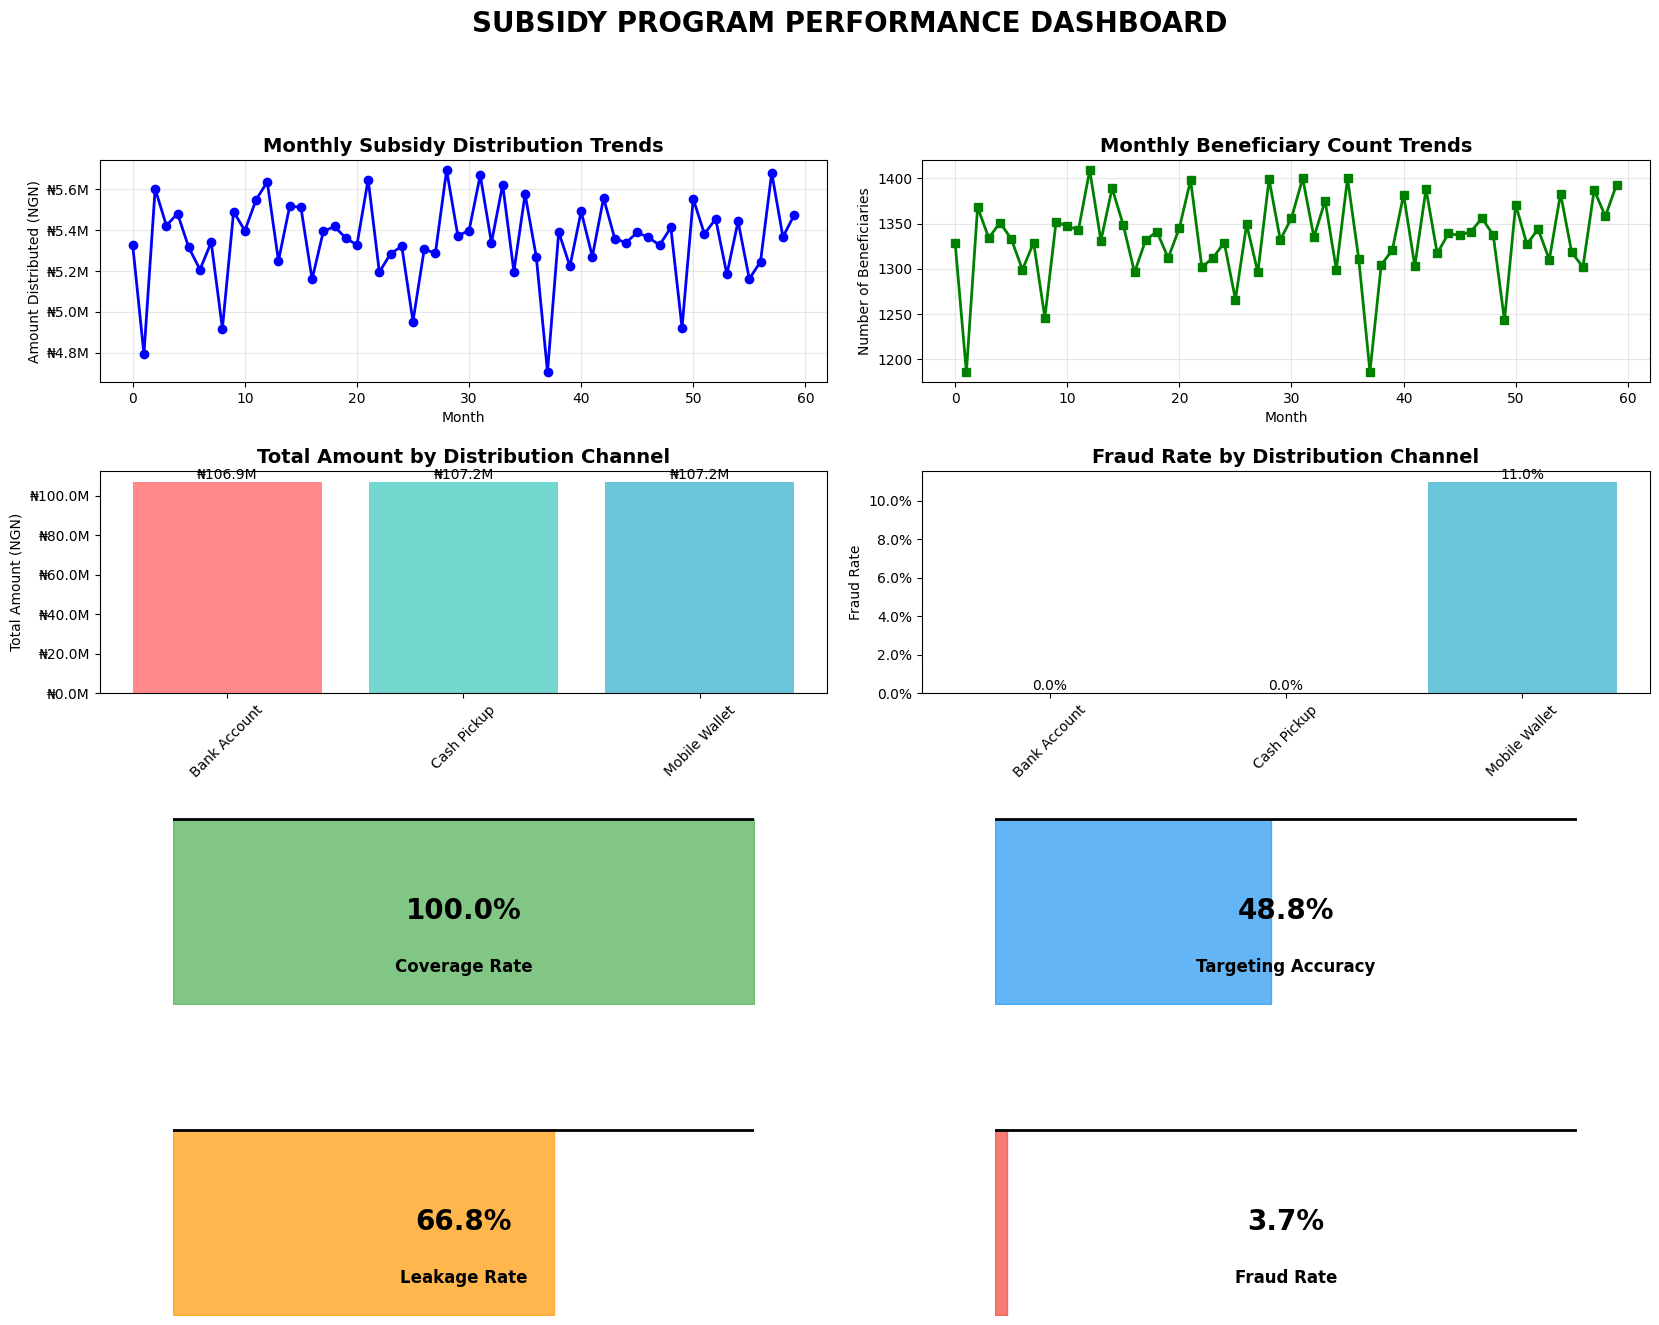

In [ ]:
def create_performance_dashboard():
    """Create comprehensive performance dashboard"""
    global df, metrics
    print("=== PERFORMANCE METRICS DASHBOARD ===")

    # Calculate additional metrics
    total_beneficiaries = len(df)
    total_amount_distributed = df['Amount (NGN)'].sum()
    average_subsidy = df['Amount (NGN)'].mean()

    # Efficiency metrics
    # Avoid division by zero if no beneficiaries
    cost_per_beneficiary = total_amount_distributed / total_beneficiaries if total_beneficiaries > 0 else 0


    # Channel efficiency
    channel_efficiency = df.groupby('Channel').agg({
        'Amount (NGN)': ['sum', 'mean', 'count'],
        'Suspected_Fraud': 'mean'
    }).round(2)

    channel_efficiency.columns = ['Total_Amount', 'Avg_Amount', 'Count', 'Fraud_Rate']

    # Time-based analysis
    # Ensure 'Date' column exists and is in datetime format
    if 'Date' in df.columns and pd.api.types.is_datetime64_any_dtype(df['Date']):
        monthly_trends = df.groupby(df['Date'].dt.to_period('M')).agg({
            'Amount (NGN)': 'sum',
            'National_ID': 'count',
            'Suspected_Fraud': 'mean'
        }).reset_index()

        monthly_trends['Date'] = monthly_trends['Date'].astype(str)
    else:
        print("Skipping monthly trends analysis due to missing or incorrect 'Date' column.")
        monthly_trends = pd.DataFrame()


    print("=== KEY PERFORMANCE INDICATORS ===")
    print(f"Total Beneficiaries: {total_beneficiaries:,}")
    print(f"Total Amount Distributed: ₦{total_amount_distributed:,.0f}")
    print(f"Average Subsidy per Beneficiary: ₦{average_subsidy:,.0f}")
    print(f"Cost per Beneficiary: ₦{cost_per_beneficiary:,.0f}")

    # Ensure metrics dictionary is not empty before printing
    if metrics:
        print(f"\nSubsidy Coverage Rate: {metrics['subsidy_coverage_rate']:.1%}")
        print(f"Targeting Accuracy: {metrics['targeting_accuracy']:.1%}")
        print(f"Leakage Rate: {metrics['leakage_rate']:.1%}")
        print(f"Overall Fraud Rate: {metrics['fraud_rate']:.1%}")
    else:
        print("\nSubsidy metrics not calculated (missing required data).")


    print("\n=== CHANNEL EFFICIENCY ===")
    print(channel_efficiency)

    # Create dashboard visualizations
    create_dashboard_visualizations(monthly_trends, channel_efficiency)

    return {
        'total_beneficiaries': total_beneficiaries,
        'total_amount_distributed': total_amount_distributed,
        'average_subsidy': average_subsidy,
        'cost_per_beneficiary': cost_per_beneficiary,
        'channel_efficiency': channel_efficiency,
        'monthly_trends': monthly_trends
    }

def create_dashboard_visualizations(monthly_trends, channel_efficiency):
    """Create dashboard visualizations"""
    fig = plt.figure(figsize=(20, 15))

    # Create a grid layout
    gs = fig.add_gridspec(4, 4, hspace=0.4, wspace=0.3)

    # 1. Monthly Distribution Trends (spans 2 columns)
    ax1 = fig.add_subplot(gs[0, :2])
    if not monthly_trends.empty:
        ax1.plot(range(len(monthly_trends)), monthly_trends['Amount (NGN)'],
                 marker='o', linewidth=2, markersize=6, color='blue')
        ax1.set_title('Monthly Subsidy Distribution Trends', fontsize=14, fontweight='bold')
        ax1.set_xlabel('Month')
        ax1.set_ylabel('Amount Distributed (NGN)')
        ax1.grid(True, alpha=0.3)
        ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'₦{x/1e6:.1f}M'))
    else:
        ax1.set_title('Monthly Subsidy Distribution Trends (Data not available)', fontsize=14, fontweight='bold')
        ax1.text(0.5, 0.5, 'Data not available', horizontalalignment='center', verticalalignment='center', transform=ax1.transAxes)

    # 2. Monthly Beneficiary Count (spans 2 columns)
    ax2 = fig.add_subplot(gs[0, 2:])
    if not monthly_trends.empty:
        ax2.plot(range(len(monthly_trends)), monthly_trends['National_ID'],
                 marker='s', linewidth=2, markersize=6, color='green')
        ax2.set_title('Monthly Beneficiary Count Trends', fontsize=14, fontweight='bold')
        ax2.set_xlabel('Month')
        ax2.set_ylabel('Number of Beneficiaries')
        ax2.grid(True, alpha=0.3)
    else:
        ax2.set_title('Monthly Beneficiary Count Trends (Data not available)', fontsize=14, fontweight='bold')
        ax2.text(0.5, 0.5, 'Data not available', horizontalalignment='center', verticalalignment='center', transform=ax2.transAxes)


    # 3. Channel Efficiency - Total Amount
    ax3 = fig.add_subplot(gs[1, :2])
    if not channel_efficiency.empty:
        bars = ax3.bar(channel_efficiency.index, channel_efficiency['Total_Amount'],
                       color=['#FF6B6B', '#4ECDC4', '#45B7D1'], alpha=0.8)
        ax3.set_title('Total Amount by Distribution Channel', fontsize=14, fontweight='bold')
        ax3.set_ylabel('Total Amount (NGN)')
        ax3.tick_params(axis='x', rotation=45)
        ax3.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'₦{x/1e6:.1f}M'))

        # Add value labels on bars
        for bar in bars:
            height = bar.get_height()
            ax3.text(bar.get_x() + bar.get_width()/2., height,
                    f'₦{height/1e6:.1f}M', ha='center', va='bottom')
    else:
        ax3.set_title('Total Amount by Distribution Channel (Data not available)', fontsize=14, fontweight='bold')
        ax3.text(0.5, 0.5, 'Data not available', horizontalalignment='center', verticalalignment='center', transform=ax3.transAxes)


    # 4. Channel Fraud Rates
    ax4 = fig.add_subplot(gs[1, 2:])
    if not channel_efficiency.empty:
        bars = ax4.bar(channel_efficiency.index, channel_efficiency['Fraud_Rate'],
                       color=['#FF6B6B', '#4ECDC4', '#45B7D1'], alpha=0.8)
        ax4.set_title('Fraud Rate by Distribution Channel', fontsize=14, fontweight='bold')
        ax4.set_ylabel('Fraud Rate')
        ax4.tick_params(axis='x', rotation=45)
        ax4.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.1%}'))

        # Add value labels on bars
        for bar in bars:
            height = bar.get_height()
            ax4.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.1%}', ha='center', va='bottom')
    else:
        ax4.set_title('Fraud Rate by Distribution Channel (Data not available)', fontsize=14, fontweight='bold')
        ax4.text(0.5, 0.5, 'Data not available', horizontalalignment='center', verticalalignment='center', transform=ax4.transAxes)


    # 5. Key Metrics Gauge Charts (2x2 grid)
    # Check if metrics dictionary is not empty before creating gauge charts
    if metrics:
        metrics_data = [
            ('Coverage Rate', metrics['subsidy_coverage_rate'], '#4CAF50'),
            ('Targeting Accuracy', metrics['targeting_accuracy'], '#2196F3'),
            ('Leakage Rate', metrics['leakage_rate'], '#FF9800'),
            ('Fraud Rate', metrics['fraud_rate'], '#F44336')
        ]

        for i, (metric_name, value, color) in enumerate(metrics_data):
            ax = fig.add_subplot(gs[2 + i//2, (i%2)*2:(i%2)*2+2])

            # Create gauge chart
            theta = np.linspace(0, np.pi, 100)
            r = np.ones_like(theta)

            ax.plot(theta, r, 'k-', linewidth=2)
            ax.fill_between(theta[:int(value*100)], 0, r[:int(value*100)],
                           color=color, alpha=0.7)

            # Add value text
            ax.text(np.pi/2, 0.5, f'{value:.1%}', ha='center', va='center',
                   fontsize=20, fontweight='bold')
            ax.text(np.pi/2, 0.2, metric_name, ha='center', va='center',
                   fontsize=12, fontweight='bold')

            ax.set_xlim(0, np.pi)
            ax.set_ylim(0, 1.2)
            ax.set_aspect('equal')
            ax.axis('off')
    else:
        # Add a placeholder if metrics are not available
        ax = fig.add_subplot(gs[2:, :])
        ax.set_title('Key Metrics (Data not available)', fontsize=14, fontweight='bold')
        ax.text(0.5, 0.5, 'Metrics not calculated', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
        ax.axis('off')


    plt.suptitle('SUBSIDY PROGRAM PERFORMANCE DASHBOARD',
                fontsize=20, fontweight='bold', y=0.98)
    plt.show()

# Run this cell for performance dashboard
dashboard_metrics = create_performance_dashboard()

## Cell 10: Summary Report Generation


In [ ]:
def generate_comprehensive_report():
    """Generate comprehensive analysis report"""
    global df, metrics, fraud_models

    print("=== COMPREHENSIVE SUBSIDY ANALYSIS REPORT ===")
    print("="*60)

    # Executive Summary
    print("\n📊 EXECUTIVE SUMMARY")
    print("-" * 30)

    total_beneficiaries = len(df)
    total_distributed = df['Amount (NGN)'].sum()
    avg_subsidy = df['Amount (NGN)'].mean()

    print(f"• Total Program Beneficiaries: {total_beneficiaries:,}")
    print(f"• Total Amount Distributed: ₦{total_distributed:,.0f}")
    print(f"• Average Subsidy per Beneficiary: ₦{avg_subsidy:,.0f}")
    print(f"• Program Coverage Rate: {metrics['subsidy_coverage_rate']:.1%}")
    print(f"• Targeting Accuracy: {metrics['targeting_accuracy']:.1%}")

    # Key Findings
    print(f"\n🔍 KEY FINDINGS")
    print("-" * 30)

    # Best performing region
    regional_performance = df.groupby('Region').agg({
        'Amount (NGN)': 'sum',
        'Suspected_Fraud': 'mean'
    })
    best_region = regional_performance['Amount (NGN)'].idxmax()
    highest_fraud_region = regional_performance['Suspected_Fraud'].idxmax()

    print(f"• Highest Distribution Region: {best_region}")
    print(f"• Highest Fraud Rate Region: {highest_fraud_region}")
    print(f"• Overall Program Leakage Rate: {metrics['leakage_rate']:.1%}")
    print(f"• Geographic Disparity Index: {metrics['geographical_disparity']:.3f}")

    # Channel performance
    channel_stats = df.groupby('Channel').agg({
        'Amount (NGN)': ['sum', 'count'],
        'Suspected_Fraud': 'mean'
    })

    most_used_channel = channel_stats[('Amount (NGN)', 'count')].idxmax()
    safest_channel = channel_stats[('Suspected_Fraud', 'mean')].idxmin()

    print(f"• Most Used Distribution Channel: {most_used_channel}")
    print(f"• Safest Distribution Channel: {safest_channel}")

    # Model Performance
    if fraud_models:
        best_model = max(fraud_models.keys(), key=lambda k: fraud_models[k]['f1_score'])
        best_f1 = fraud_models[best_model]['f1_score']
        print(f"• Best Fraud Detection Model: {best_model} (F1: {best_f1:.3f})")

    # Recommendations
    print(f"\n💡 STRATEGIC RECOMMENDATIONS")
    print("-" * 30)

    recommendations = []

    if metrics['leakage_rate'] > 0.1:
        recommendations.append("• Strengthen eligibility verification to reduce leakage")

    if metrics['fraud_rate'] > 0.15:
        recommendations.append("• Implement enhanced fraud detection mechanisms")

    if metrics['targeting_accuracy'] < 0.7:
        recommendations.append("• Improve targeting to reach more low-income beneficiaries")

    if metrics['geographical_disparity'] > 1.2:
        recommendations.append("• Address regional disparities in subsidy distribution")

    # Channel-specific recommendations
    channel_fraud_rates = df.groupby('Channel')['Suspected_Fraud'].mean()
    high_fraud_channels = channel_fraud_rates[channel_fraud_rates > 0.2]

    if len(high_fraud_channels) > 0:
        for channel in high_fraud_channels.index:
            recommendations.append(f"• Review security measures for {channel} channel")

    # Print recommendations
    if recommendations:
        for rec in recommendations:
            print(rec)
    else:
        print("• Current program performance meets acceptable standards")
        print("• Continue monitoring key metrics for sustained performance")

    # Risk Assessment
    print(f"\n⚠️  RISK ASSESSMENT")
    print("-" * 30)

    risk_level = "LOW"
    risk_factors = []

    if metrics['fraud_rate'] > 0.2:
        risk_level = "HIGH"
        risk_factors.append("High fraud rate detected")
    elif metrics['fraud_rate'] > 0.15:
        risk_level = "MEDIUM"
        risk_factors.append("Moderate fraud rate")

    if metrics['leakage_rate'] > 0.15:
        risk_level = "HIGH"
        risk_factors.append("Significant program leakage")
    elif metrics['leakage_rate'] > 0.1:
        if risk_level != "HIGH":
            risk_level = "MEDIUM"
        risk_factors.append("Moderate program leakage")

    if metrics['geographical_disparity'] > 1.5:
        if risk_level == "LOW":
            risk_level = "MEDIUM"
        risk_factors.append("High geographical inequality")

    print(f"Overall Risk Level: {risk_level}")
    if risk_factors:
        print("Risk Factors:")
        for factor in risk_factors:
            print(f"  - {factor}")

    print("Report generated successfully! ✅")

    return {
        'total_beneficiaries': total_beneficiaries,
        'total_distributed': total_distributed,
        'risk_level': risk_level,
        'recommendations': recommendations,
        'best_model': best_model if fraud_models else None
    }

# Run this cell to generate the comprehensive report
final_report = generate_comprehensive_report()

print("\n🎉 ALL ANALYSIS COMPLETED!")
print("="*50)
print("You can now:")
print("1. Review individual analysis results in each cell")
print("2. Access the interactive map: 'subsidy_geographic_analysis.html'")
print("3. Use the trained models for future predictions")
print("4. Export results to external systems")
print("="*50)

=== COMPREHENSIVE SUBSIDY ANALYSIS REPORT ===

📊 EXECUTIVE SUMMARY
------------------------------
• Total Program Beneficiaries: 80,025
• Total Amount Distributed: ₦321,244,735
• Average Subsidy per Beneficiary: ₦4,014
• Program Coverage Rate: 100.0%
• Targeting Accuracy: 48.8%

🔍 KEY FINDINGS
------------------------------
• Highest Distribution Region: Kano
• Highest Fraud Rate Region: Yobe
• Overall Program Leakage Rate: 66.8%
• Geographic Disparity Index: nan
• Most Used Distribution Channel: Bank Account
• Safest Distribution Channel: Bank Account
• Best Fraud Detection Model: Decision Tree (F1: 0.067)

💡 STRATEGIC RECOMMENDATIONS
------------------------------
• Strengthen eligibility verification to reduce leakage
• Improve targeting to reach more low-income beneficiaries

⚠️  RISK ASSESSMENT
------------------------------
Overall Risk Level: HIGH
Risk Factors:
  - Significant program leakage
Report generated successfully! ✅

🎉 ALL ANALYSIS COMPLETED!
You can now:
1. Review indi

# Cell 8: Prediction Inference


In [ ]:
def predict_fraud_on_new_data(new_data):
    """
    Uses the best-performing fraud detection model to make predictions on new data.
    Automatically calculates necessary derived features if not present.

    Args:
        new_data (pd.DataFrame): DataFrame containing new data for prediction.

    Returns:
        pd.Series: Predicted fraud labels (1 for fraud, 0 for normal).
    """
    global fraud_models, X_train # Access fraud_models and X_train from global scope
    print("=== MAKING PREDICTIONS ON NEW DATA ===")

    if not fraud_models or X_train is None:
        print("Error: Fraud models or training data (X_train) not available.")
        return None

    # Identify the best performing model based on F1-score
    best_model_name = max(fraud_models.keys(), key=lambda k: fraud_models[k]['f1_score'])
    best_model_info = fraud_models[best_model_name]
    best_model = best_model_info['model']

    print(f"Using best model: {best_model_name}")

    # Prepare new_data for prediction - apply the same preprocessing as X_train
    new_data_processed = new_data.copy()

    # --- Automatically calculate derived features if not present ---
    print("Calculating derived features...")
    if 'Amount (NGN)' in new_data_processed.columns and 'Household_Dependents' in new_data_processed.columns:
        if 'Amount_per_Dependent' not in new_data_processed.columns:
             # Avoid division by zero
             new_data_processed['Amount_per_Dependent'] = new_data_processed.apply(
                 lambda row: row['Amount (NGN)'] / row['Household_Dependents'] if row['Household_Dependents'] > 0 else 0, axis=1
             )
             print("  'Amount_per_Dependent' calculated.")
        if 'Energy_per_Dependent' not in new_data_processed.columns and 'Monthly_Energy_Consumption_kWh' in new_data_processed.columns:
             # Avoid division by zero
             new_data_processed['Energy_per_Dependent'] = new_data_processed.apply(
                  lambda row: row['Monthly_Energy_Consumption_kWh'] / row['Household_Dependents'] if row['Household_Dependents'] > 0 else 0, axis=1
             )
             print("  'Energy_per_Dependent' calculated.")

    if 'Date' in new_data_processed.columns:
        if 'Days_Since_Distribution' not in new_data_processed.columns:
            try:
                # Ensure 'Date' is datetime type
                new_data_processed['Date'] = pd.to_datetime(new_data_processed['Date'], errors='coerce')
                # Handle potential NaT values after coercion
                if not new_data_processed['Date'].isnull().all():
                     new_data_processed['Days_Since_Distribution'] = (datetime.now() - new_data_processed['Date']).dt.days.fillna(-1) # Use -1 or another indicator for invalid dates
                     print("  'Days_Since_Distribution' calculated.")
                else:
                     print("  Could not calculate 'Days_Since_Distribution': 'Date' column contains only invalid dates.")
                     new_data_processed['Days_Since_Distribution'] = -1 # Add column with default value if all dates invalid
            except Exception as e:
                print(f"  Could not calculate 'Days_Since_Distribution'. Error: {e}")
                new_data_processed['Days_Since_Distribution'] = -1 # Add column with default value on error
    else:
         print("  Could not calculate 'Days_Since_Distribution': 'Date' column not found.")


    # --- Handle categorical variables using one-hot encoding ---
    print("Handling categorical features...")
    categorical_cols = ['Gender', 'Region', 'Income_Level', 'Channel', 'Subsidy_Type']
    for col in categorical_cols:
        if col in new_data_processed.columns:
            # Use pd.get_dummies which handles new categories gracefully (will create columns with 0s)
            dummies = pd.get_dummies(new_data_processed[col], prefix=col)
            new_data_processed = pd.concat([new_data_processed, dummies], axis=1)
            new_data_processed = new_data_processed.drop(columns=[col])


    # --- Align columns with X_train - add missing columns and drop extra ones ---
    print("Aligning columns with training data...")
    missing_cols = set(X_train.columns) - set(new_data_processed.columns)
    for c in missing_cols:
        new_data_processed[c] = 0
    # Ensure the order of columns is the same as X_train
    new_data_processed = new_data_processed[X_train.columns]

    # Scale numeric features ONLY if the best model requires it (which none of the current models do after removing SVM)
    # Removed SVM-specific scaling logic

    # Make predictions
    predictions = best_model.predict(new_data_processed)

    print("✅ Predictions made successfully!")
    return pd.Series(predictions, name='Predicted_Fraud')

# prediction on sample new data

# Create a small sample DataFrame representing new data for a single ID
# Note: Derived features are INTENTIONALLY NOT included here to test automatic calculation
sample_new_data_single = pd.DataFrame({
    'National_ID': ['ID99999'],
    'Age': [35],
    'Gender': ['Male'],
    'Region': ['Lagos'],
    'Income_Level': ['Low'],
    'Household_Dependents': [3],
    'Monthly_Energy_Consumption_kWh': [180],
    'Amount (NGN)': [7000],
    'Channel': ['Mobile Wallet'],
    'Date': [pd.to_datetime('2024-08-01')], # Use datetime object directly
    'Wallet_Activity_Status': ['Active'],
    'Wallet_Balance (NGN)': [10000.0],
    'Days_Since_Last_Transaction': [5],
    'Avg_Monthly_Wallet_Balance': [8000.0],
    'Suspected_Fraud': [0] # Actual fraud status (for testing, not used in prediction)
})

# Call the prediction function with the single ID data
predicted_fraud_status_single = predict_fraud_on_new_data(sample_new_data_single)

if predicted_fraud_status_single is not None:
    print("\nPredicted Fraud Status for Single Sample ID:")
    # Display the prediction clearly, perhaps with the ID
    if 'National_ID' in sample_new_data_single.columns:
        prediction_output = pd.DataFrame({
            'National_ID': sample_new_data_single['National_ID'],
            'Predicted_Fraud': predicted_fraud_status_single
        })
        display(prediction_output)
    else:
        print(predicted_fraud_status_single)

=== MAKING PREDICTIONS ON NEW DATA ===
Using best model: Decision Tree
Calculating derived features...
  'Amount_per_Dependent' calculated.
  'Energy_per_Dependent' calculated.
  'Days_Since_Distribution' calculated.
Handling categorical features...
Aligning columns with training data...
✅ Predictions made successfully!

Predicted Fraud Status for Single Sample ID:


,National_ID,Predicted_Fraud
0,ID99999,1
